<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [247]:
import numpy as np
import scipy.stats as stats
import math
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
import patsy
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LassoCV, RidgeCV
import matplotlib

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

set2 = sns.color_palette('Set2')

# set larger default fonts for presentation-friendliness
mpl.rc('figure', figsize=(10, 8))
mpl.rc('axes', labelsize=16, titlesize=20)

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [660]:
# Load the data
house = pd.read_csv('./housing.csv')
descriptions = open('./data_description.txt').read().splitlines()

In [661]:
# So much text  ಠ_ಠ
descriptions

['MSSubClass: Identifies the type of dwelling involved in the sale.\t',
 '',
 '        20\t1-STORY 1946 & NEWER ALL STYLES',
 '        30\t1-STORY 1945 & OLDER',
 '        40\t1-STORY W/FINISHED ATTIC ALL AGES',
 '        45\t1-1/2 STORY - UNFINISHED ALL AGES',
 '        50\t1-1/2 STORY FINISHED ALL AGES',
 '        60\t2-STORY 1946 & NEWER',
 '        70\t2-STORY 1945 & OLDER',
 '        75\t2-1/2 STORY ALL AGES',
 '        80\tSPLIT OR MULTI-LEVEL',
 '        85\tSPLIT FOYER',
 '        90\tDUPLEX - ALL STYLES AND AGES',
 '       120\t1-STORY PUD (Planned Unit Development) - 1946 & NEWER',
 '       150\t1-1/2 STORY PUD - ALL AGES',
 '       160\t2-STORY PUD - 1946 & NEWER',
 '       180\tPUD - MULTILEVEL - INCL SPLIT LEV/FOYER',
 '       190\t2 FAMILY CONVERSION - ALL STYLES AND AGES',
 '',
 'MSZoning: Identifies the general zoning classification of the sale.',
 '\t\t',
 '       A\tAgriculture',
 '       C\tCommercial',
 '       FV\tFloating Village Residential',
 '       I\tIndustri

In [662]:
# Good riddance

house = house.drop(house[(house.MSZoning == 'A') | (house.MSZoning == 'C (all)') |\
                         (house.MSZoning == 'I')].index)

In [663]:
# First look at correlations
# I'll use features that correlate at >= .5

corr=house.corr()["SalePrice"]
corr[np.argsort(corr, axis=0)[::-1]]

SalePrice        1.000000
OverallQual      0.789031
GrLivArea        0.708658
GarageCars       0.642135
GarageArea       0.629831
TotalBsmtSF      0.612088
1stFlrSF         0.603300
FullBath         0.556674
TotRmsAbvGrd     0.533355
YearBuilt        0.517602
YearRemodAdd     0.501186
GarageYrBlt      0.486058
MasVnrArea       0.475950
Fireplaces       0.463264
BsmtFinSF1       0.384475
LotFrontage      0.354848
OpenPorchSF      0.329491
WoodDeckSF       0.320770
2ndFlrSF         0.319774
HalfBath         0.280882
LotArea          0.264715
BsmtFullBath     0.224054
BsmtUnfSF        0.216152
BedroomAbvGr     0.162008
ScreenPorch      0.110540
PoolArea         0.092396
MoSold           0.051987
3SsnPorch        0.043807
BsmtFinSF2      -0.014145
BsmtHalfBath    -0.017561
LowQualFinSF    -0.018755
MiscVal         -0.021052
Id              -0.024353
YrSold          -0.025391
MSSubClass      -0.087487
OverallCond     -0.089084
EnclosedPorch   -0.120765
KitchenAbvGr    -0.137825
Name: SalePr

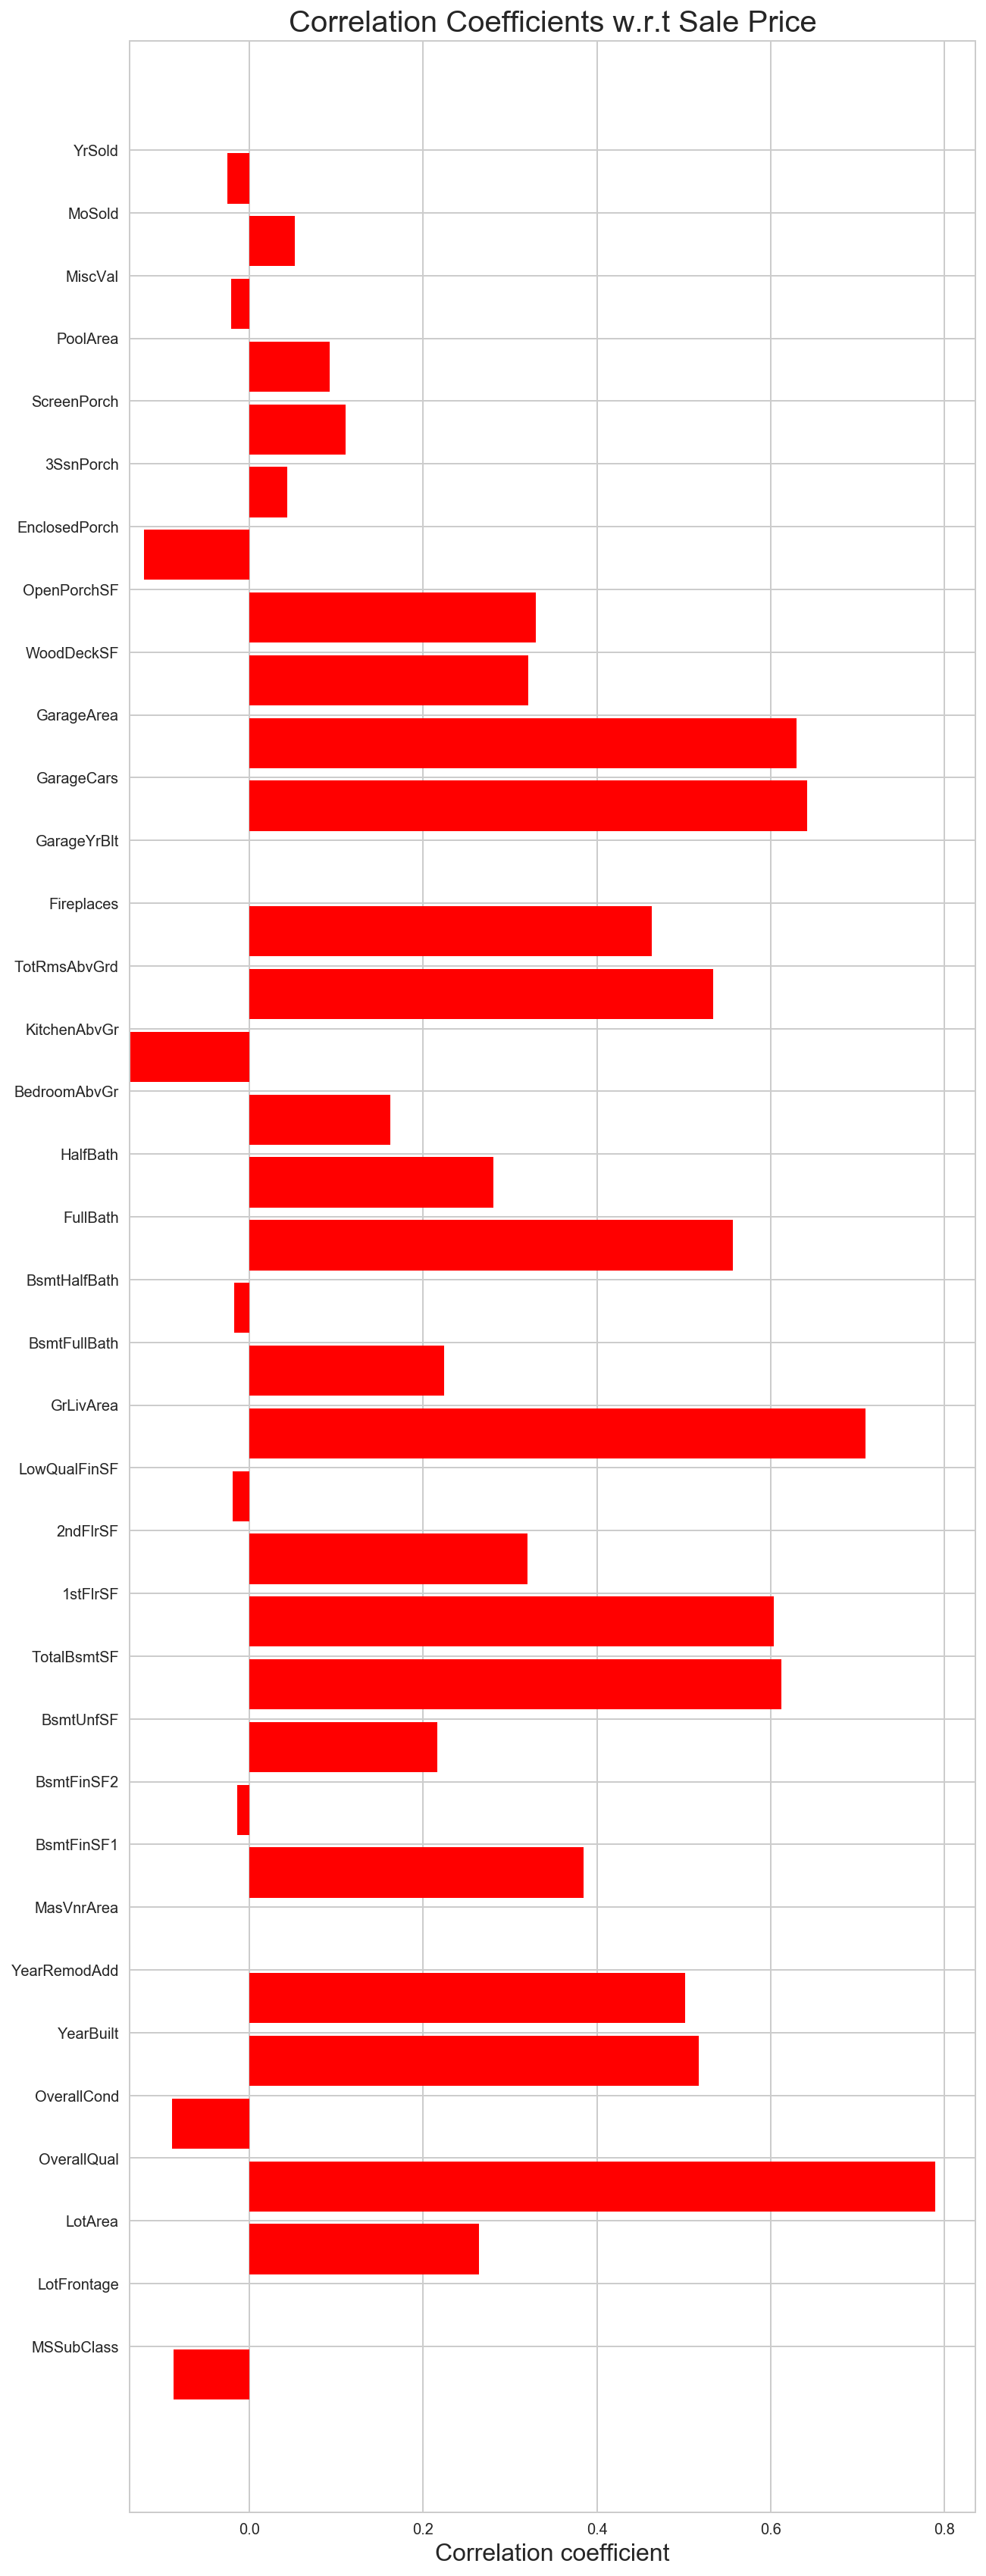

In [664]:
#plotting correlations

num_feat=house.columns[house.dtypes!=object]
num_feat=num_feat[1:-1] 
labels = []
values = []
for col in num_feat:
    labels.append(col)
    values.append(np.corrcoef(house[col].values, house.SalePrice.values)[0,1])
    
ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(10,30))
rects = ax.barh(ind, np.array(values), color='red')
ax.set_yticks(ind+((width)/2.))
ax.set_yticklabels(labels, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation Coefficients w.r.t Sale Price");

In [665]:
house.columns

Index([u'Id', u'MSSubClass', u'MSZoning', u'LotFrontage', u'LotArea',
       u'Street', u'Alley', u'LotShape', u'LandContour', u'Utilities',
       u'LotConfig', u'LandSlope', u'Neighborhood', u'Condition1',
       u'Condition2', u'BldgType', u'HouseStyle', u'OverallQual',
       u'OverallCond', u'YearBuilt', u'YearRemodAdd', u'RoofStyle',
       u'RoofMatl', u'Exterior1st', u'Exterior2nd', u'MasVnrType',
       u'MasVnrArea', u'ExterQual', u'ExterCond', u'Foundation', u'BsmtQual',
       u'BsmtCond', u'BsmtExposure', u'BsmtFinType1', u'BsmtFinSF1',
       u'BsmtFinType2', u'BsmtFinSF2', u'BsmtUnfSF', u'TotalBsmtSF',
       u'Heating', u'HeatingQC', u'CentralAir', u'Electrical', u'1stFlrSF',
       u'2ndFlrSF', u'LowQualFinSF', u'GrLivArea', u'BsmtFullBath',
       u'BsmtHalfBath', u'FullBath', u'HalfBath', u'BedroomAbvGr',
       u'KitchenAbvGr', u'KitchenQual', u'TotRmsAbvGrd', u'Functional',
       u'Fireplaces', u'FireplaceQu', u'GarageType', u'GarageYrBlt',
       u'GarageFinish',

In [791]:
# Slimming down to fixed features  (b^_^)b

house_fixed_feats = house[['Id', 'LotFrontage', 'LotShape', \
                               'LandContour', 'LotConfig', 'LandSlope', \
                               'Neighborhood', 'BldgType', 'YearBuilt', 'YearRemodAdd', \
                               'Foundation', '1stFlrSF', 'GrLivArea', \
                               'SaleType', 'SaleCondition', 'SalePrice', \
                               'LotArea', 'LotConfig', \
                               'TotalBsmtSF', 'YrSold', \
                               'FullBath', 'GarageArea', 'TotRmsAbvGrd', \
                               ]]

In [792]:
# Checking types in dataset

house_fixed_feats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Data columns (total 23 columns):
Id               1450 non-null int64
LotFrontage      1191 non-null float64
LotShape         1450 non-null object
LandContour      1450 non-null object
LotConfig        1450 non-null object
LandSlope        1450 non-null object
Neighborhood     1450 non-null object
BldgType         1450 non-null object
YearBuilt        1450 non-null int64
YearRemodAdd     1450 non-null int64
Foundation       1450 non-null object
1stFlrSF         1450 non-null int64
GrLivArea        1450 non-null int64
SaleType         1450 non-null object
SaleCondition    1450 non-null object
SalePrice        1450 non-null int64
LotArea          1450 non-null int64
LotConfig        1450 non-null object
TotalBsmtSF      1450 non-null int64
YrSold           1450 non-null int64
FullBath         1450 non-null int64
GarageArea       1450 non-null int64
TotRmsAbvGrd     1450 non-null int64
dtypes: float64(1), int64(12),

In [793]:
# Feature Engineering

dummy_columns = ['SaleCondition', 'SaleType', 'BldgType', 'Neighborhood', 'LotConfig', \
                  'Foundation', 'LandSlope', 'LandContour', 'LotShape'
                ]
house_dummies = pd.get_dummies(house[dummy_columns])

In [794]:
# Put it together

house_fixed_feats = house_fixed_feats.join(house_dummies)

In [795]:
# Drop these columns
droppers = ['SaleCondition', 'SaleType', 'BldgType', 'Neighborhood', 'LotConfig', \
            'Foundation', 'LandSlope', 'LandContour', 'LotShape'
           ]

house_fixed_feats = house_fixed_feats.drop(droppers, axis=1)

In [796]:
# Get rid of the NaNs, but using backfill for data retention

house_fixed_feats.dropna(inplace=True) #fillna(method='backfill',inplace=True)

In [797]:
# Feature Engineering
# Let's look at the age of the house when sold

#house_fixed_feats['HouseAge'] = house_fixed_feats['YrSold'] - house_fixed_feats['YearBuilt']

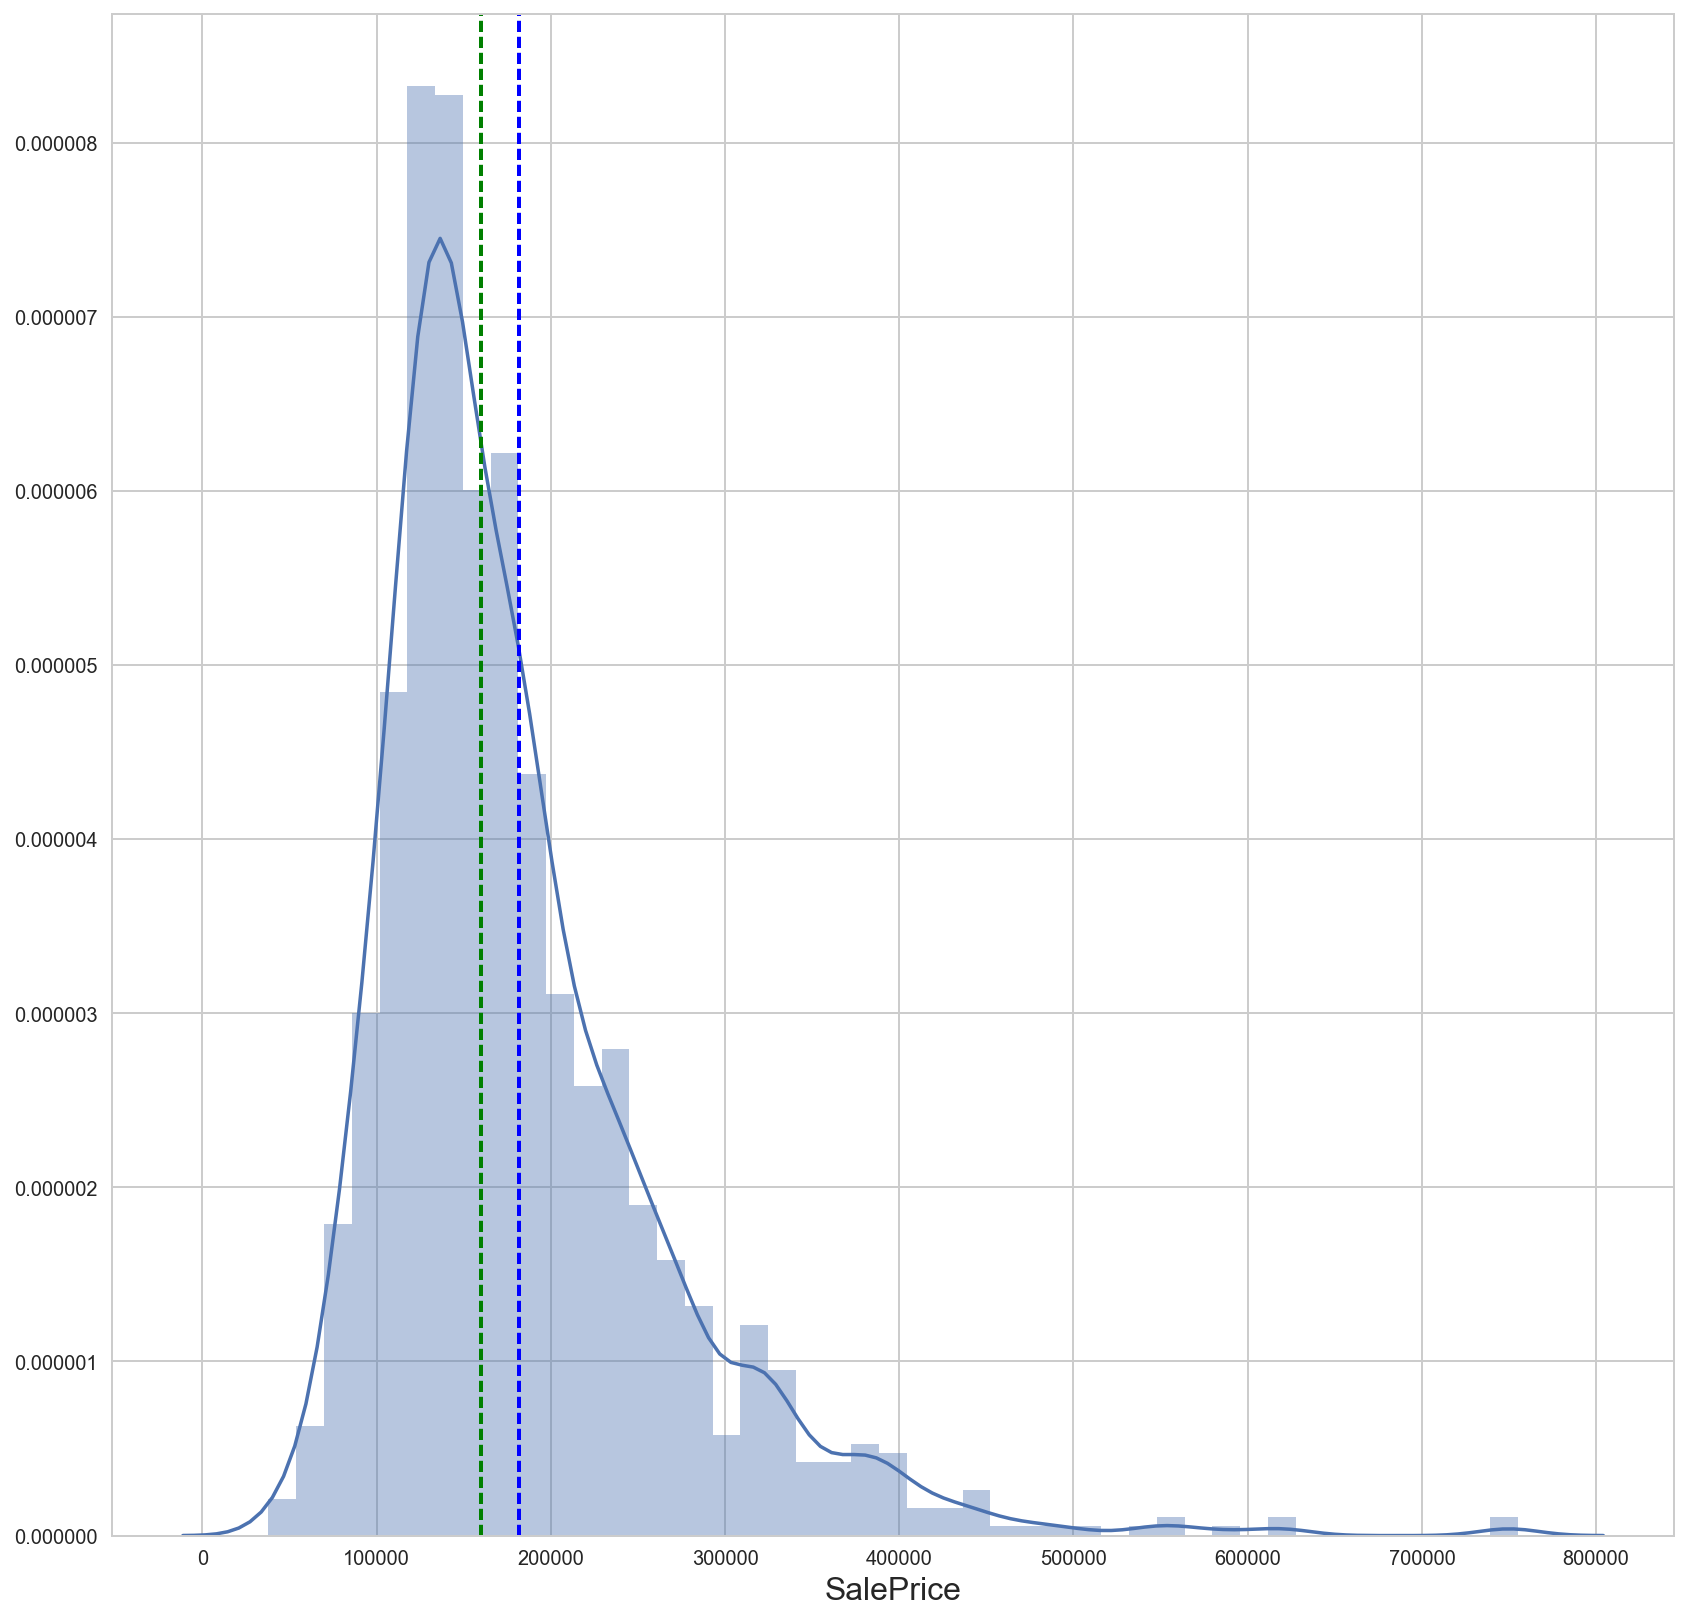

In [798]:
# Checking the distribution of SalePrices for a normal distribution

sns.distplot(house_fixed_feats['SalePrice'])

plt.axvline(house_fixed_feats['SalePrice'].mean(), color='b', linestyle='dashed', linewidth=2)
plt.axvline(house_fixed_feats['SalePrice'].median(), color='g', linestyle='dashed', linewidth=2)

plt.show()

In [756]:
# The SalePrice is left skewed with a long, right tail.
# Normalizing the data logarithmically will correct that.

house_fixed_feats['SalePrice'] = np.log(house_fixed_feats['SalePrice'])

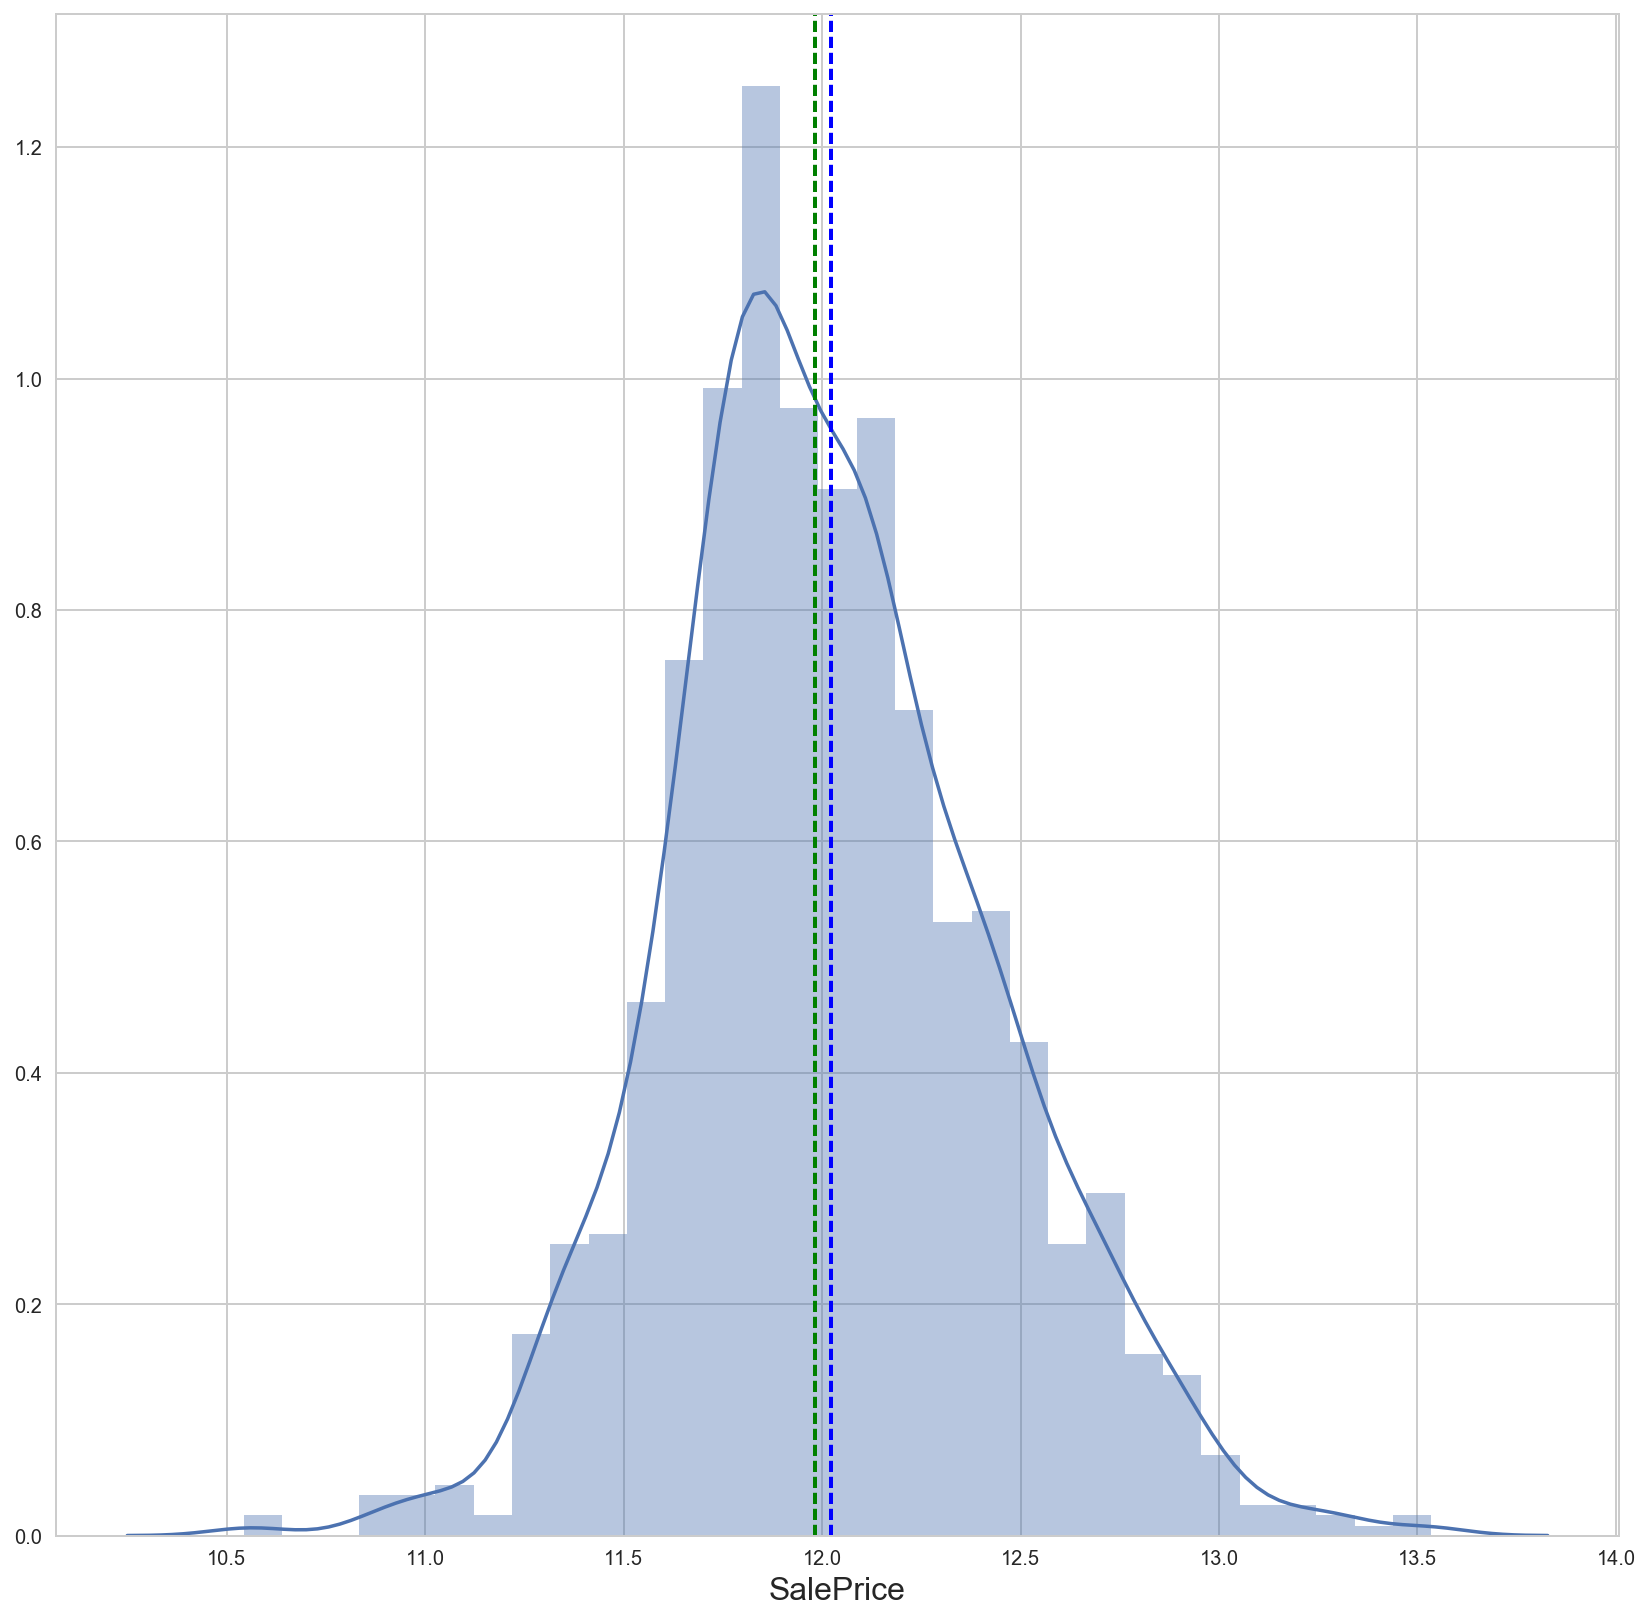

In [757]:
# Checking the distribution of SalePrices again

sns.distplot(house_fixed_feats['SalePrice'])

plt.axvline(house_fixed_feats['SalePrice'].mean(), color='b', linestyle='dashed', linewidth=2)
plt.axvline(house_fixed_feats['SalePrice'].median(), color='g', linestyle='dashed', linewidth=2)

plt.show()

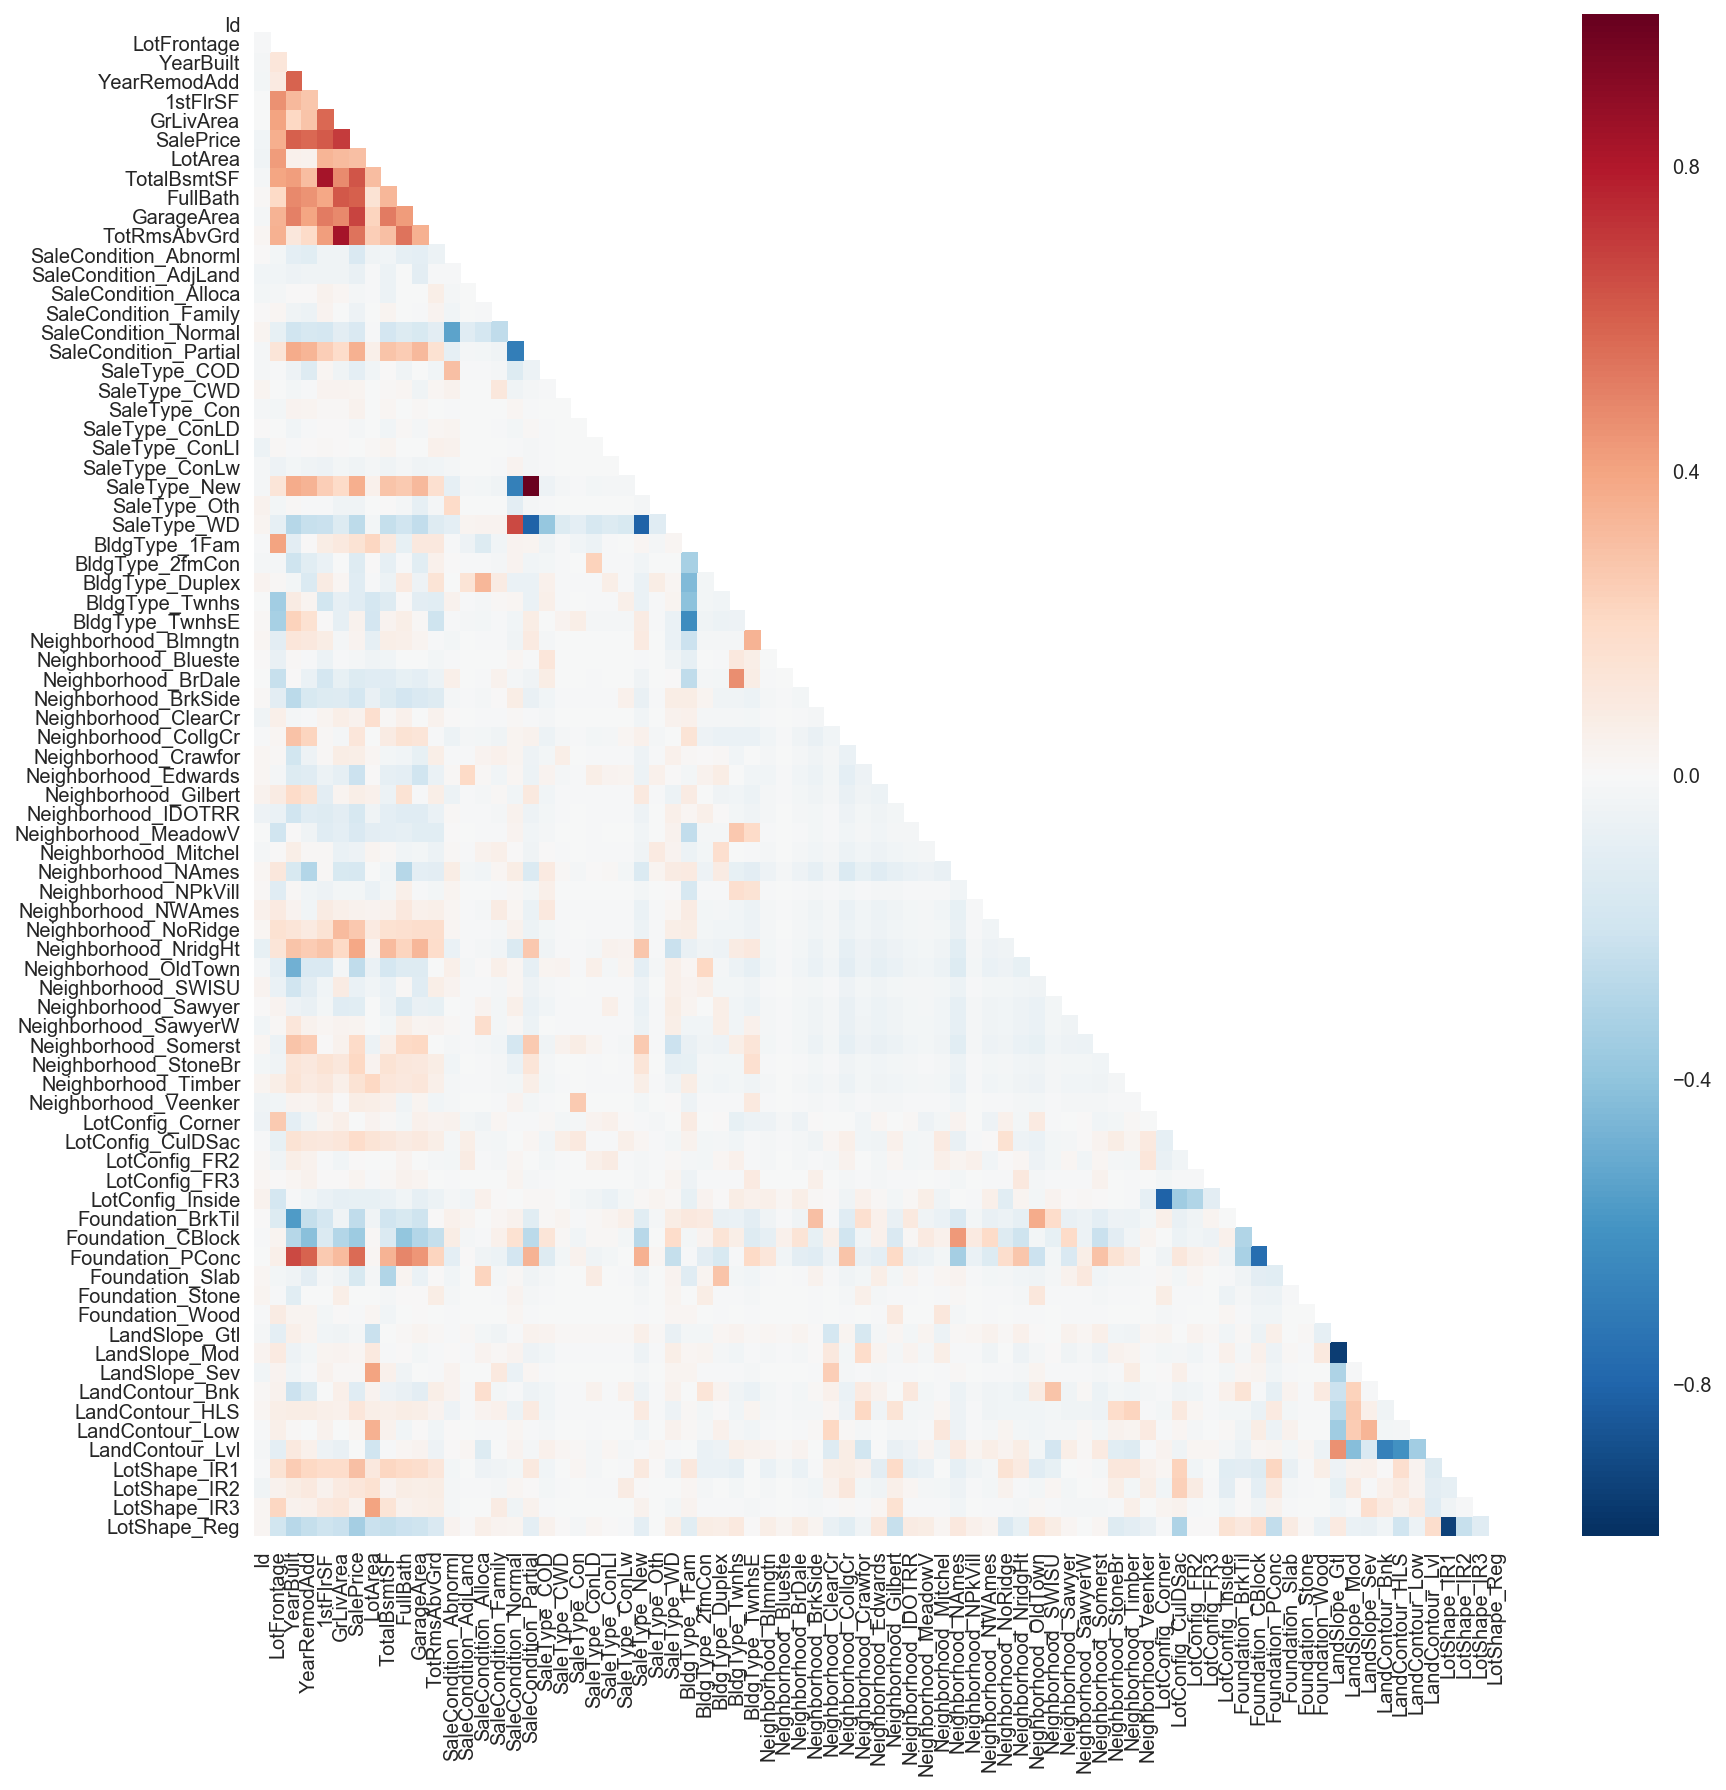

In [758]:
# Looking for correlations within the dataset

house_corr = house_fixed_feats.corr()

# Set the default matplotlib figure size to 7x7:
plt.rcParams['figure.figsize']=(14,14)

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(house_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
ax = sns.heatmap(house_corr, mask=mask)

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=10)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=10)

# If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
plt.show()

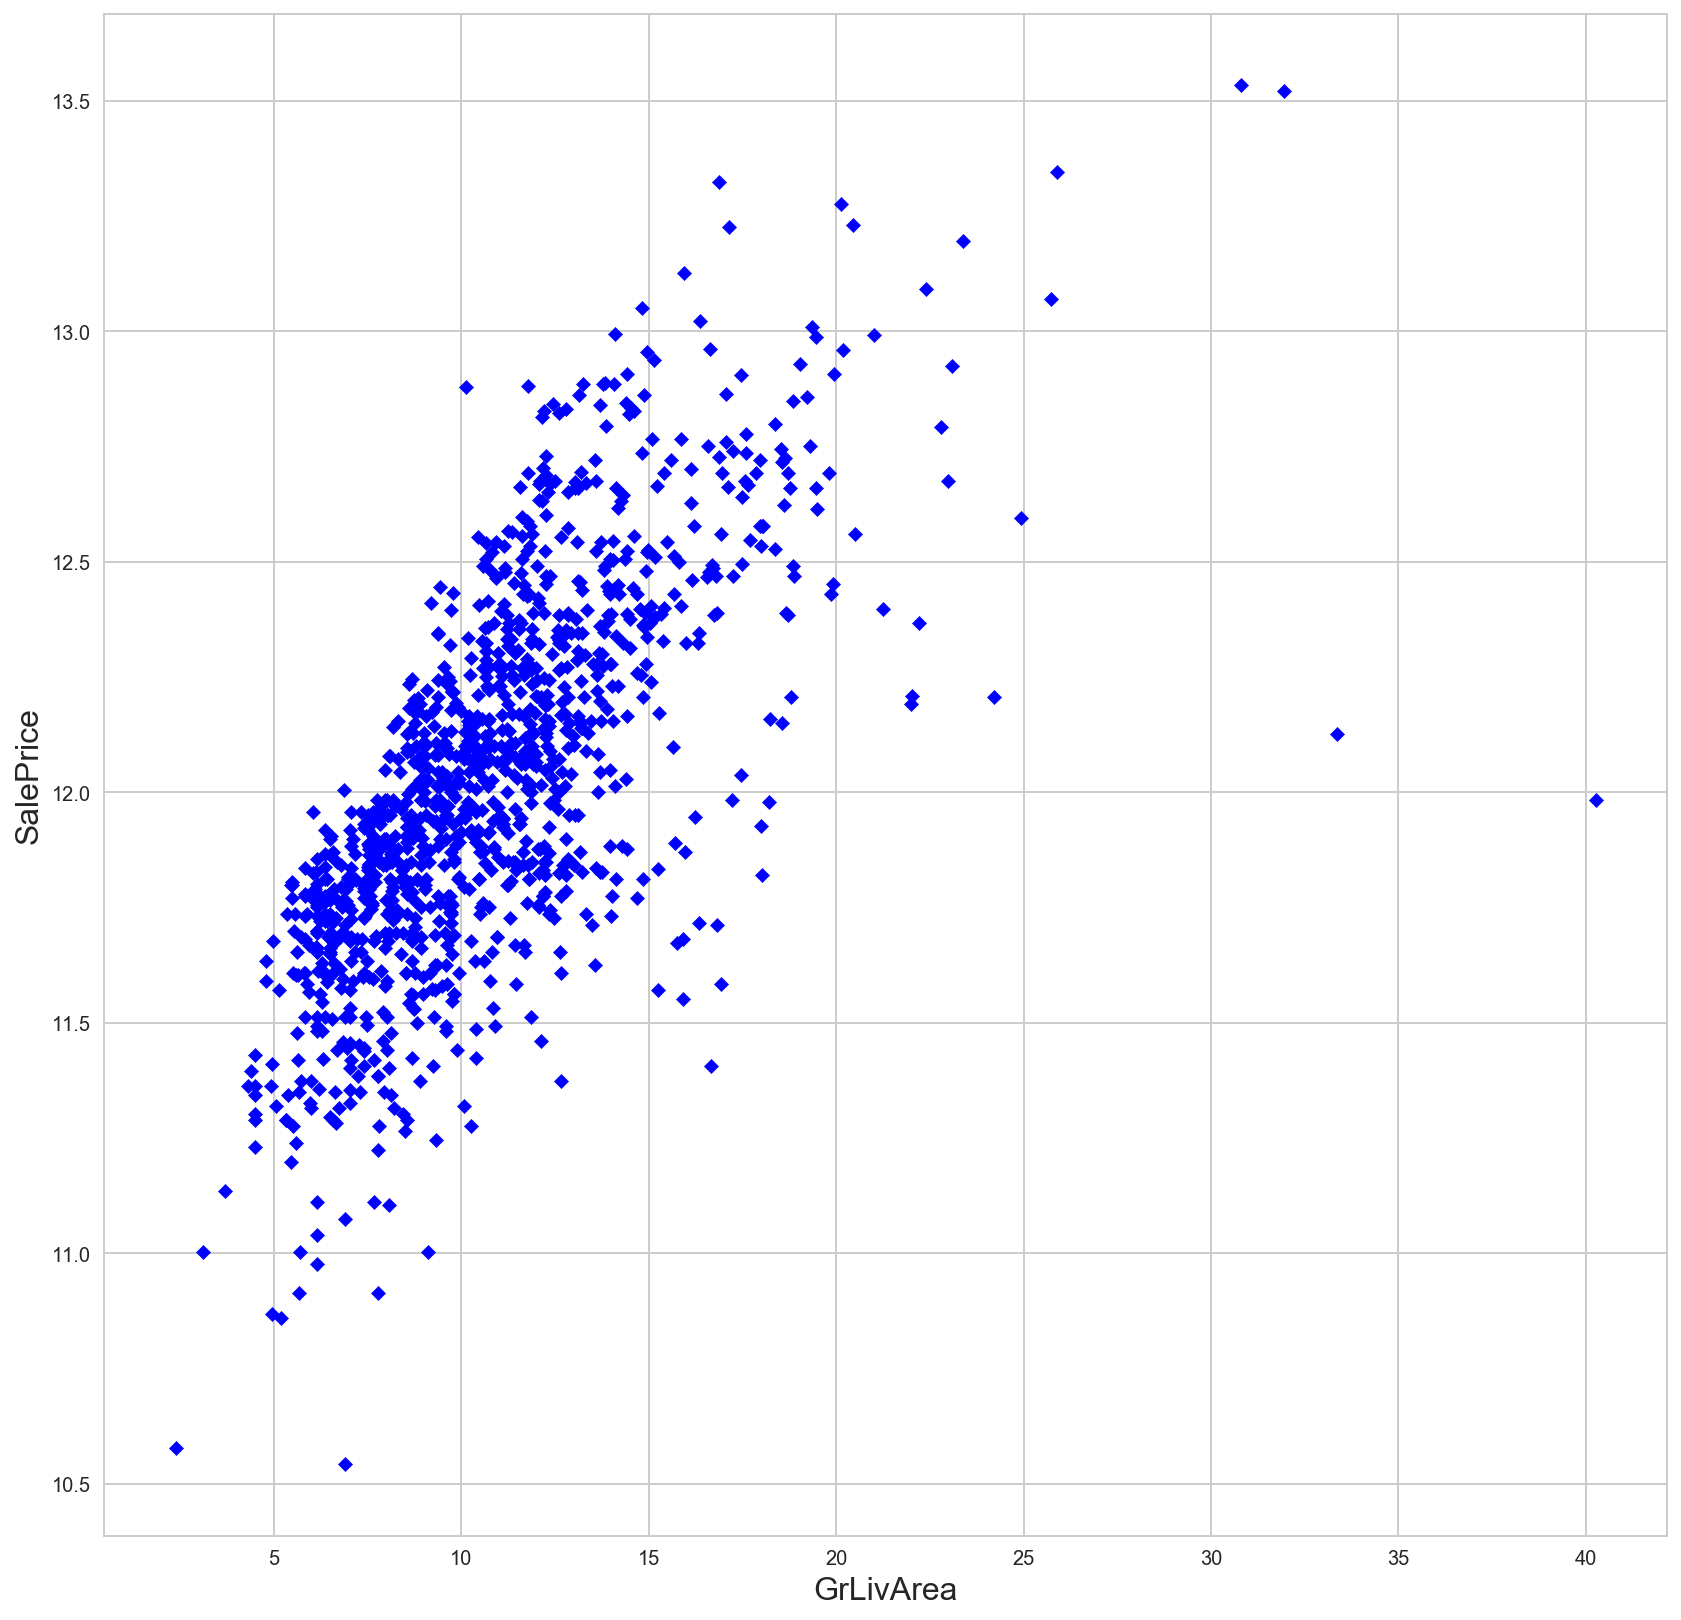

MSE: 13.7769969898
R^2: 0.904806943225


In [759]:
# Let's check out the correlation between the GrLivArea and SalePrice

import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

X = house_fixed_feats['GrLivArea']
y = house_fixed_feats['SalePrice']

# Note the difference in argument order
# optionally, you can chain "fit()" to the model object
model = sm.OLS(y, X).fit()
predictions = model.predict(X)

# Plot the model
plt.scatter(predictions, y, s=25, c='b', marker='D', zorder=10)
plt.ylabel("SalePrice")
plt.xlabel('GrLivArea')
plt.show()

print "MSE:", mean_squared_error(y, predictions)
print 'R^2:', model.rsquared

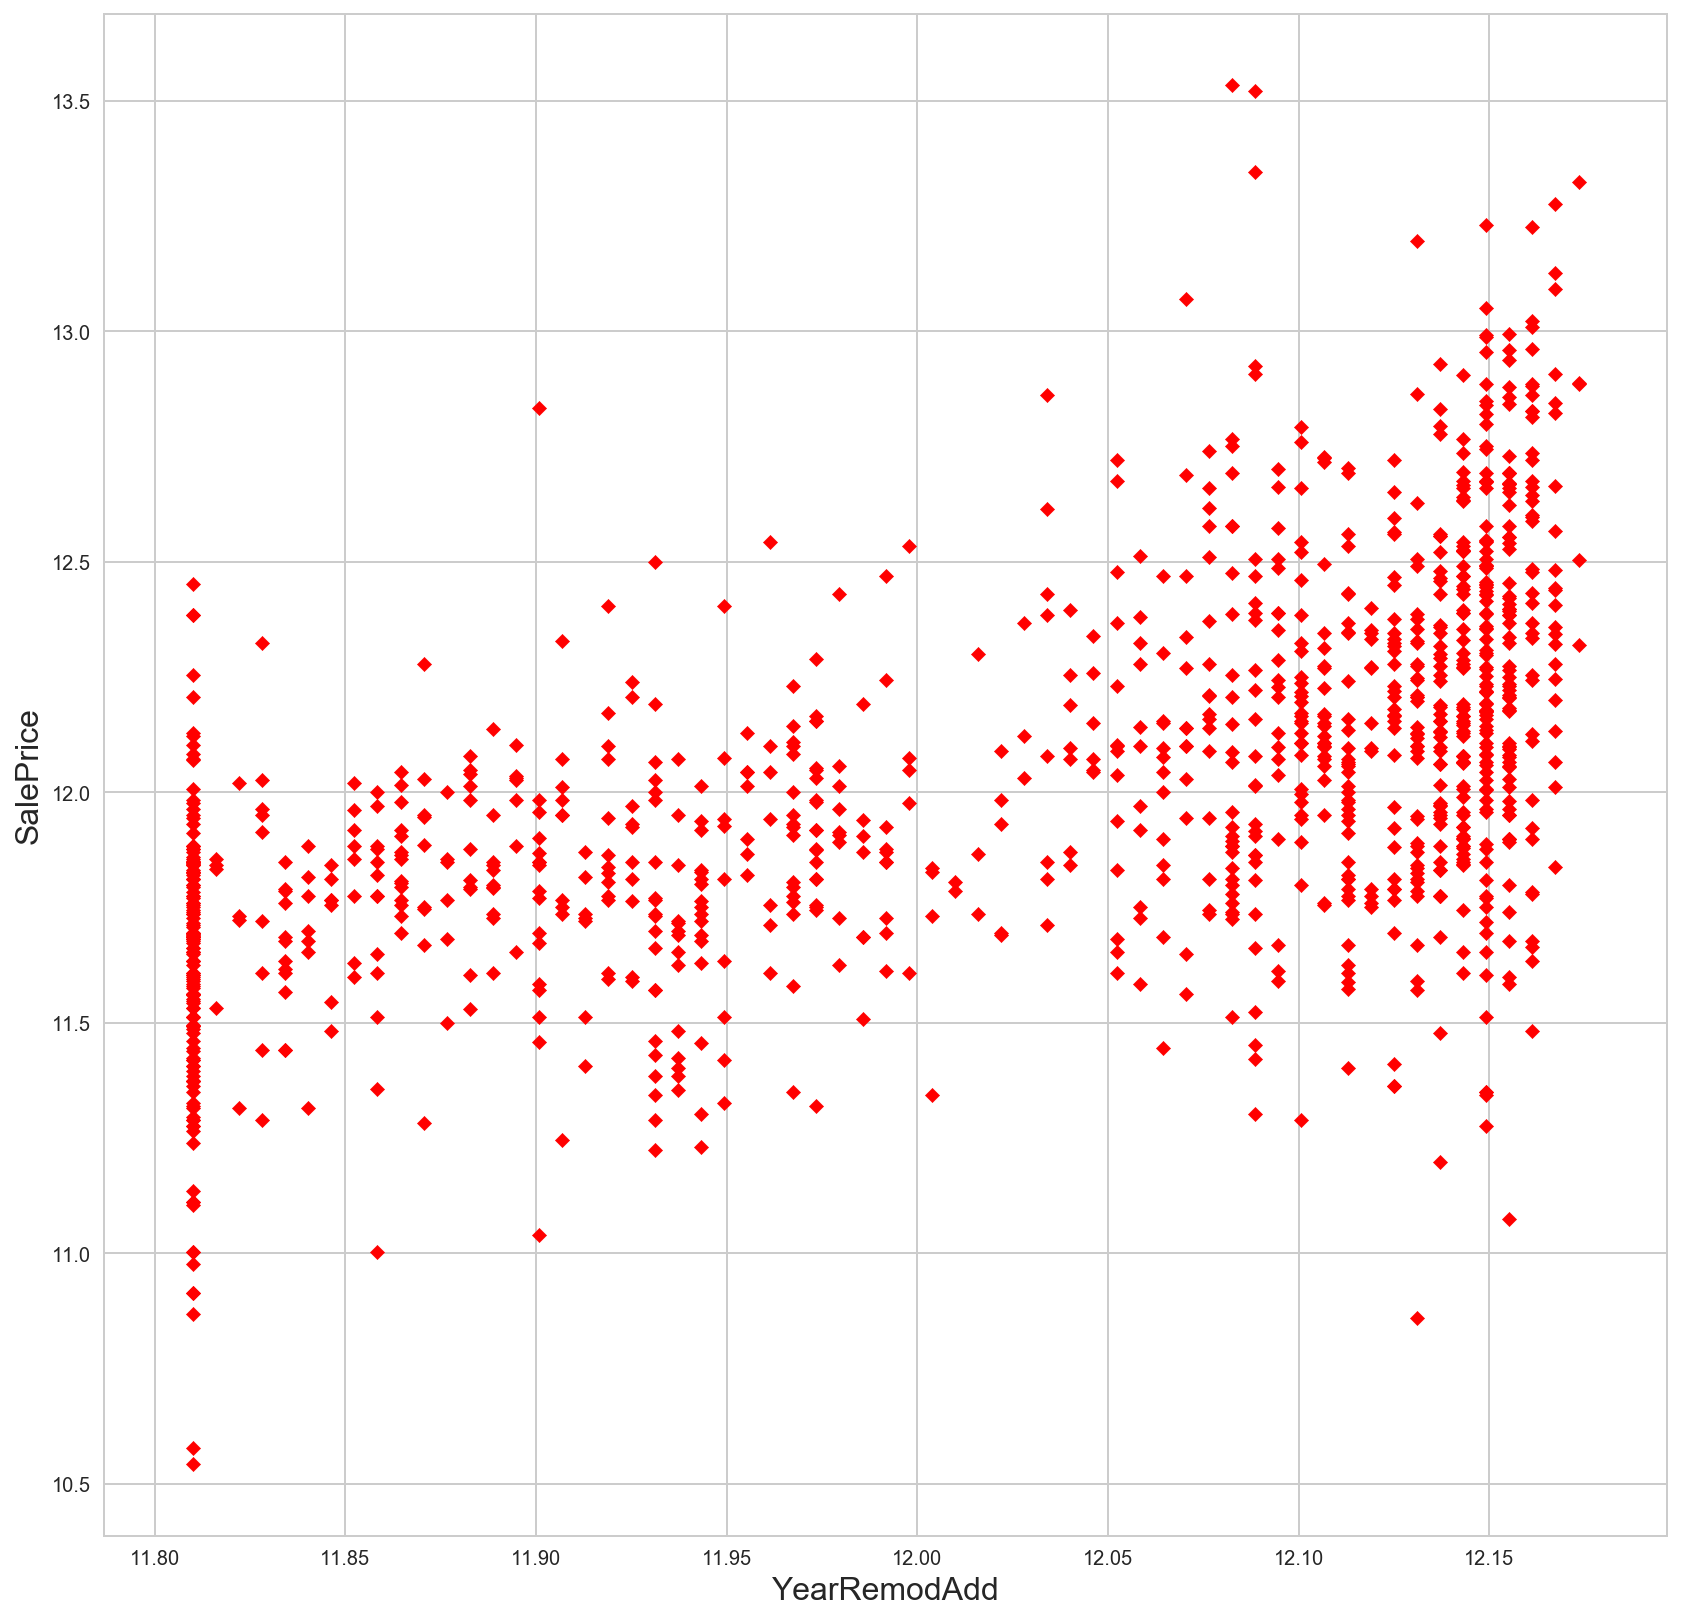

MSE: 0.122220532362
R^2: 0.999155509282


In [760]:
# Let's check out the correlation between the YearRemodAdd and SalePrice

import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

X = house_fixed_feats['YearRemodAdd']
y = house_fixed_feats['SalePrice']

# Note the difference in argument order
# optionally, you can chain "fit()" to the model object
model = sm.OLS(y, X).fit()
predictions = model.predict(X)

# Plot the model
plt.scatter(predictions, y, s=25, c='r', marker='D', zorder=10)
plt.ylabel("SalePrice")
plt.xlabel('YearRemodAdd')
plt.show()

print "MSE:", mean_squared_error(y, predictions)
print 'R^2:', model.rsquared

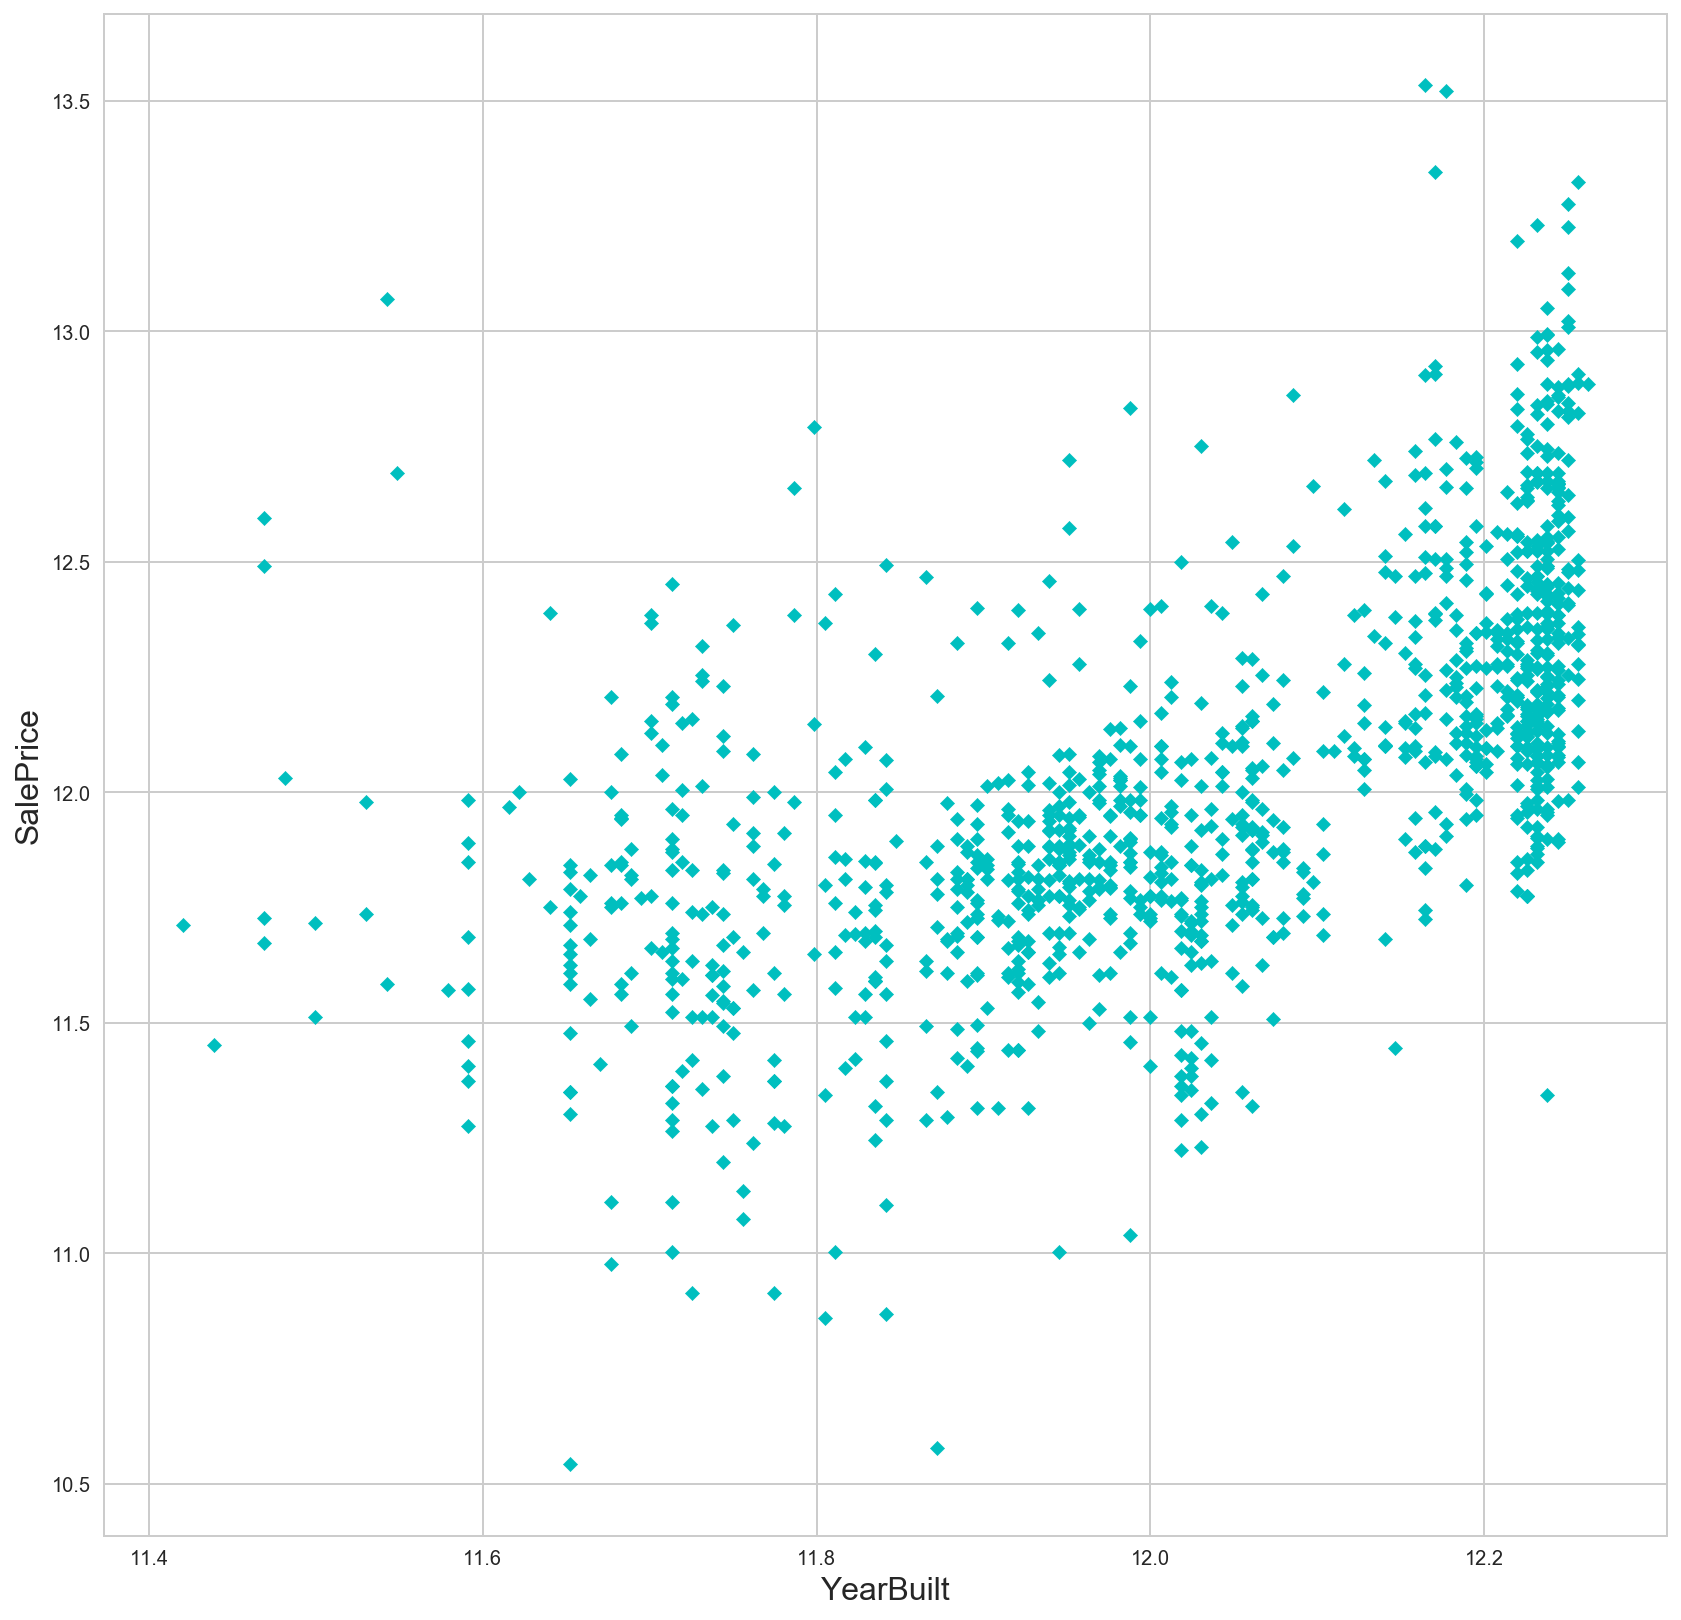

MSE: 0.108767574668
R^2: 0.999248463368


In [761]:
# Let's check out the correlation between the YearBuilt and SalePrice

import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

X = house_fixed_feats['YearBuilt']
y = house_fixed_feats['SalePrice']

# Note the difference in argument order
# optionally, you can chain "fit()" to the model object
model = sm.OLS(y, X).fit()
predictions = model.predict(X)

# Plot the model
plt.scatter(predictions, y, s=25, c='c', marker='D', zorder=10)
plt.ylabel("SalePrice")
plt.xlabel('YearBuilt')
plt.show()

print "MSE:", mean_squared_error(y, predictions)
print 'R^2:', model.rsquared

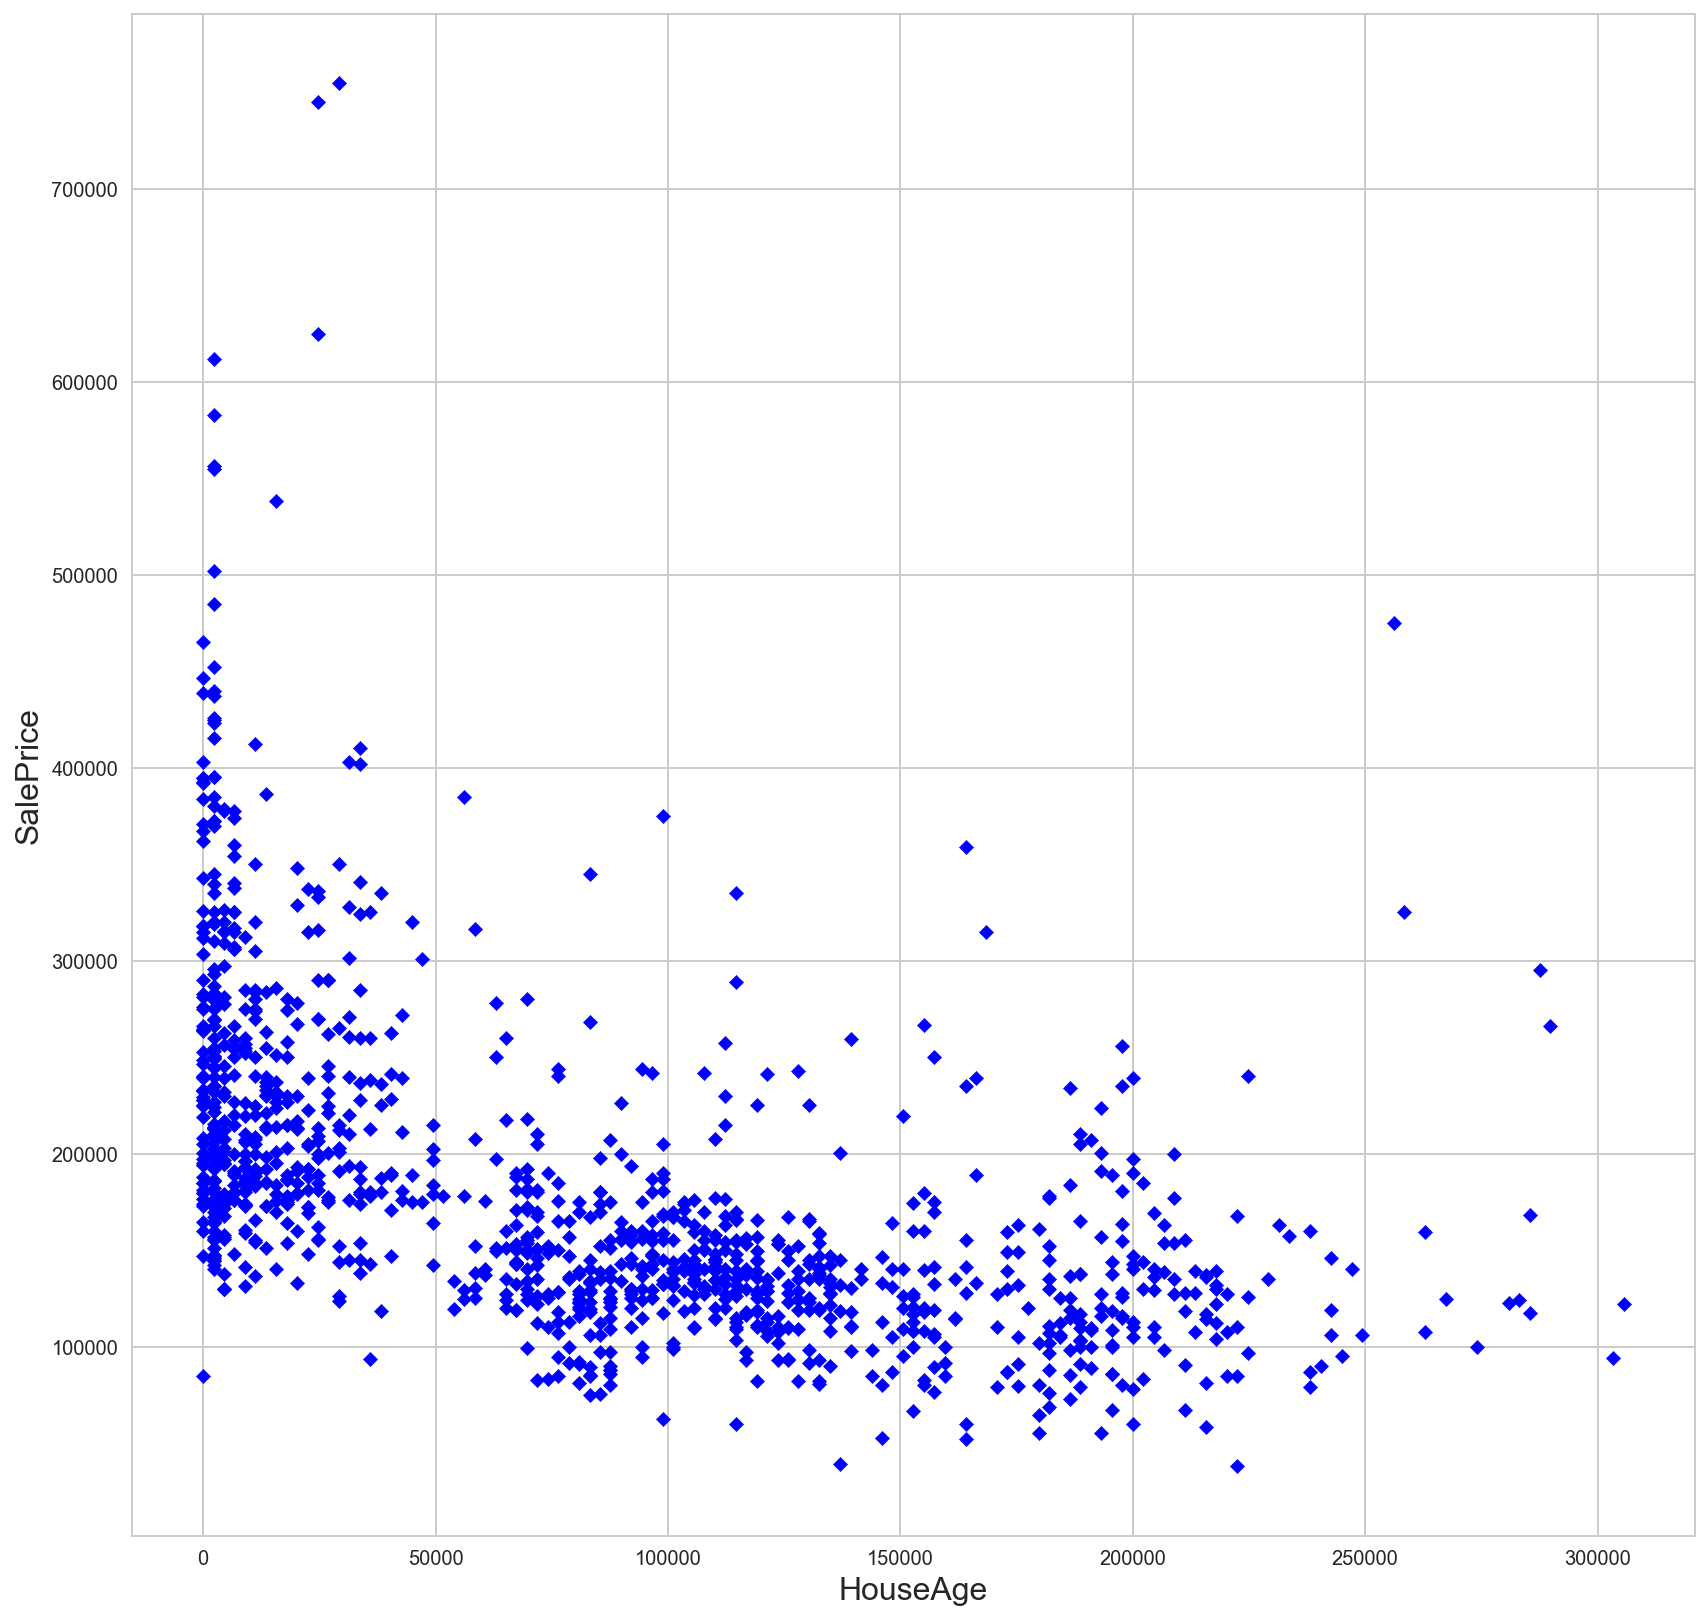

MSE: 28015994362.1
R^2: 0.297905203065


In [775]:
# Let's check out the correlation between the HouseAge and SalePrice

import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

X = house_fixed_feats['HouseAge']
y = house_fixed_feats['SalePrice']

# Note the difference in argument order
# optionally, you can chain "fit()" to the model object
model = sm.OLS(y, X).fit()
predictions = model.predict(X)

# Plot the model
plt.scatter(predictions, y, s=25, c='b', marker='D', zorder=10)
plt.ylabel("SalePrice")
plt.xlabel('HouseAge')
plt.show()

print "MSE:", mean_squared_error(y, predictions)
print 'R^2:', model.rsquared

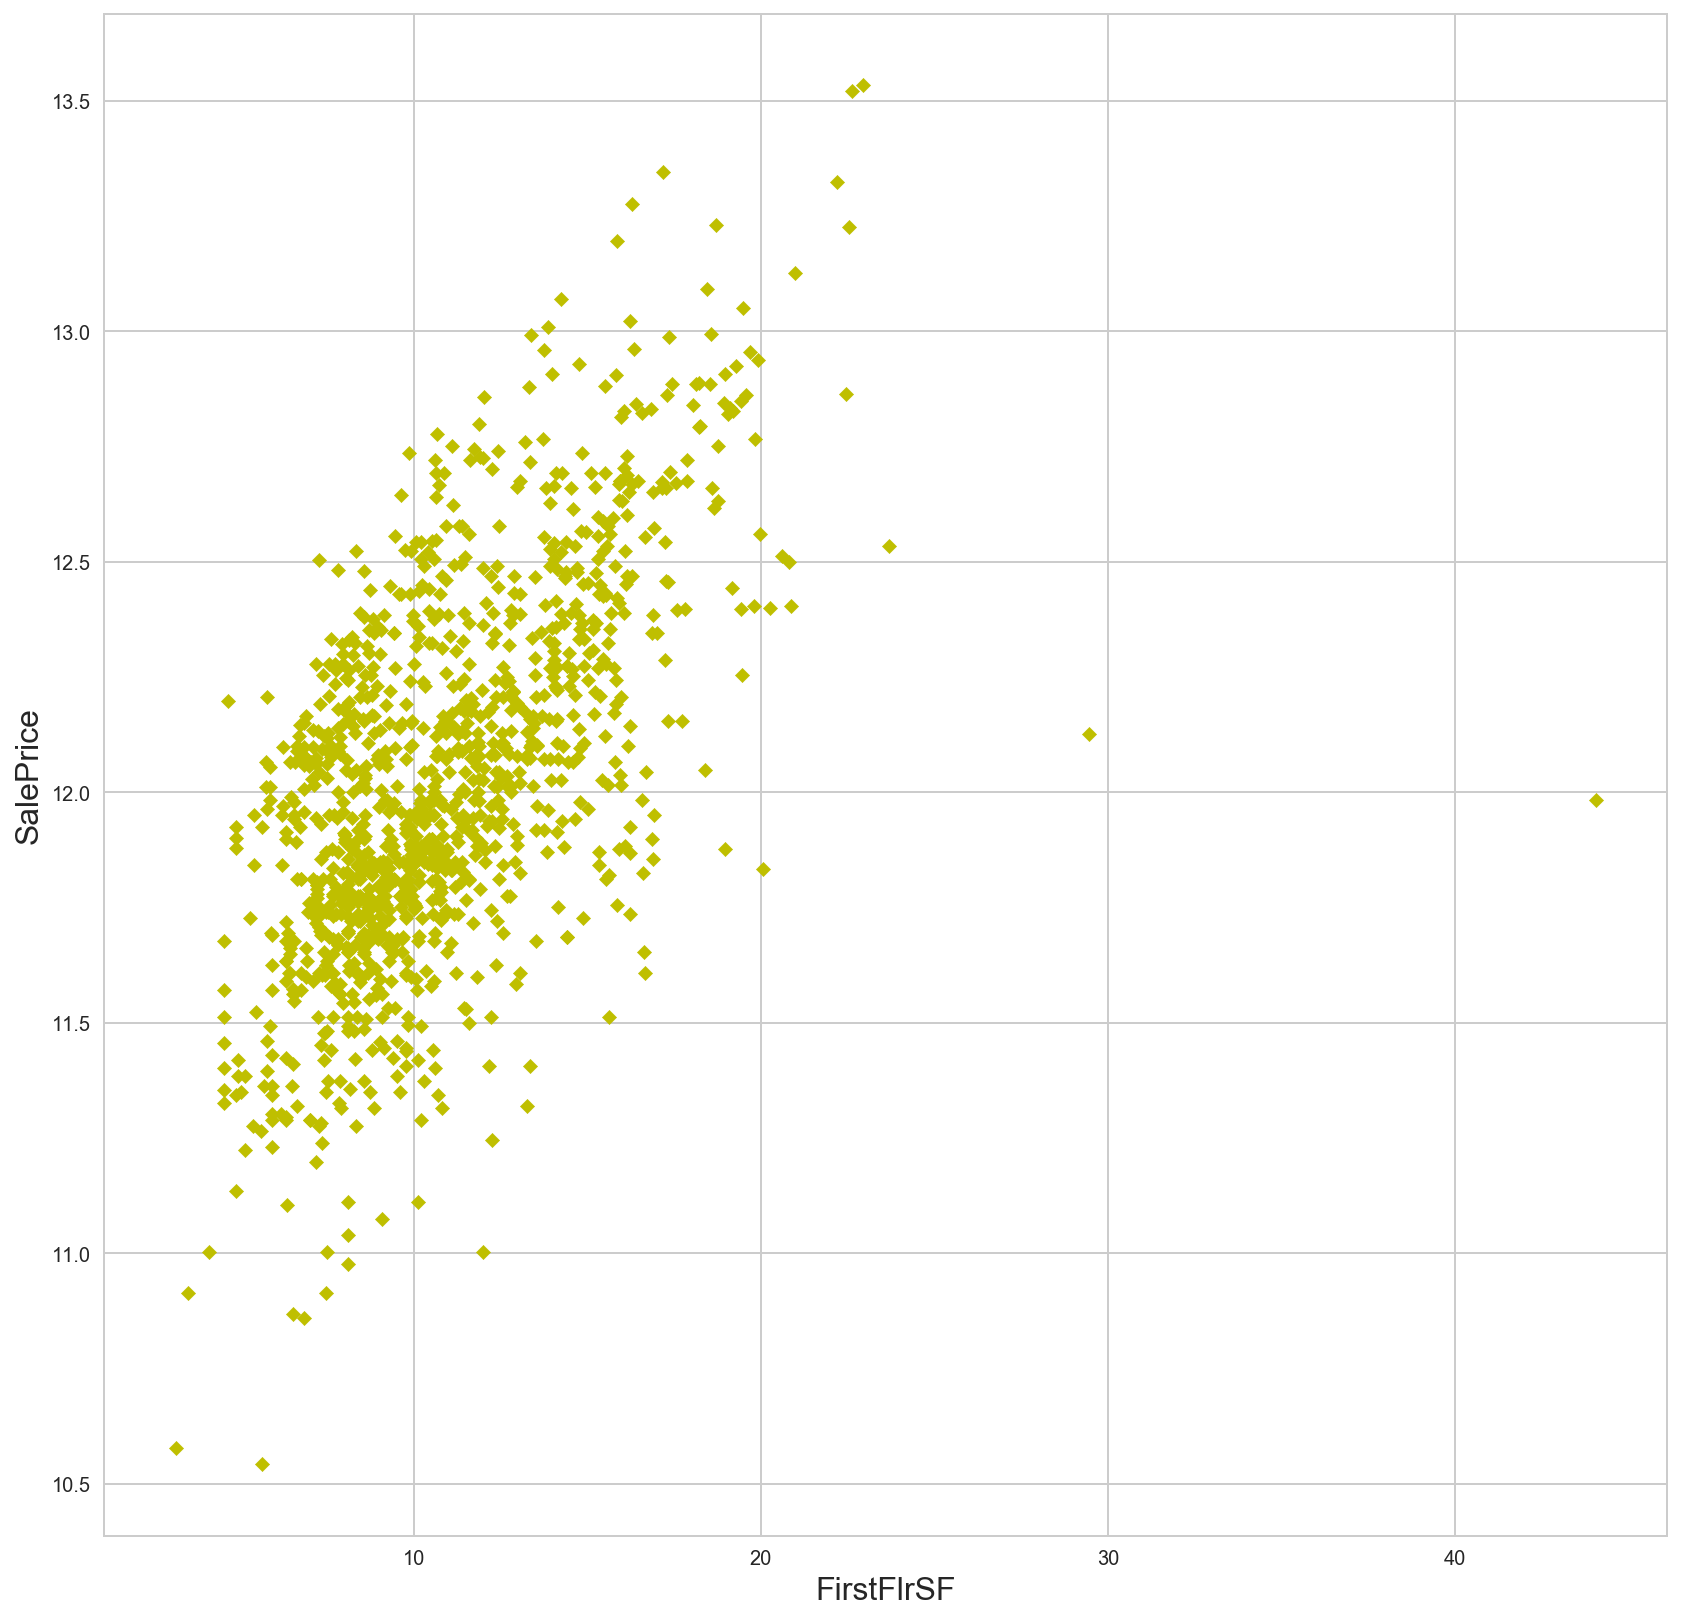

MSE: 12.7583471825
R^2: 0.911845370323


In [763]:
# Let's check out the correlation between the 1stFlrSF and SalePrice

import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

X = house_fixed_feats['1stFlrSF']
y = house_fixed_feats['SalePrice']

# Note the difference in argument order
# optionally, you can chain "fit()" to the model object
model = sm.OLS(y, X).fit()
predictions = model.predict(X)

# Plot the model
plt.scatter(predictions, y, s=25, c='y', marker='D', zorder=10)
plt.ylabel("SalePrice")
plt.xlabel('FirstFlrSF')
plt.show()

print "MSE:", mean_squared_error(y, predictions)
print 'R^2:', model.rsquared

In [799]:
# Plotting a linear regression with all of the features

linreg_X = house_fixed_feats
linreg_y = linreg_X['SalePrice']
linreg_X = linreg_X.drop('SalePrice', axis=1)

from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression(normalize=True)
lin_reg.fit(linreg_X, linreg_y)

prediction = pd.DataFrame()
prediction['Price'] = lin_reg.predict(linreg_X)
lin_reg.score(linreg_X, linreg_y)

0.81946107857012163

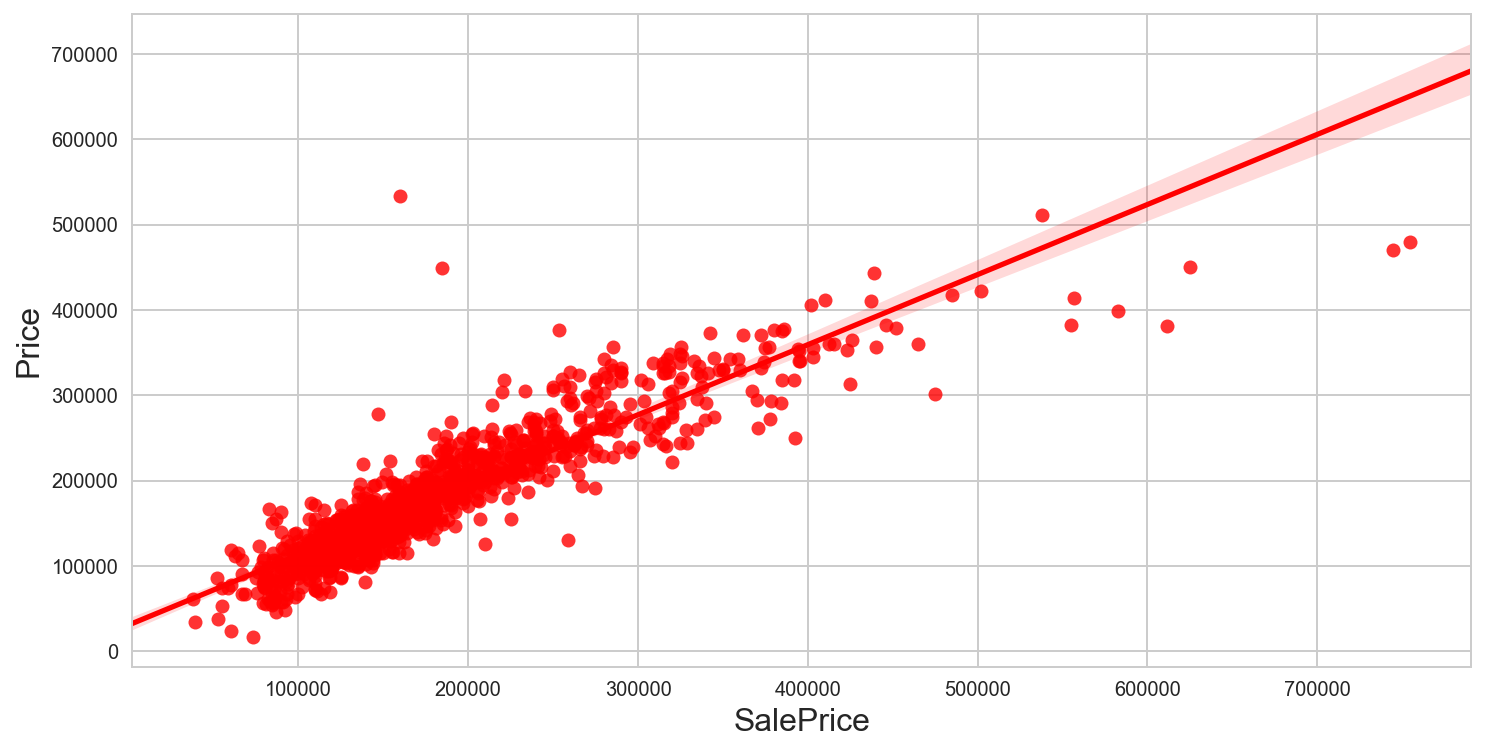

In [800]:
fig, ax_arr = plt.subplots(1,1, figsize=(12,6))

axis0 = sns.regplot(linreg_y, prediction['Price'], color='red', ax=ax_arr)

In [801]:
# Create the pre/post 2010 splits

house_pre2010 = house_fixed_feats[house_fixed_feats.YrSold < 2010]
house_2010 = house_fixed_feats[house_fixed_feats.YrSold == 2010]

In [802]:
# Get the targets

house_target_pre = house_pre2010.SalePrice
house_target = house_2010.SalePrice

In [803]:
# Drop the targets from the tests

house_pre2010 = house_pre2010.drop('SalePrice', axis=1)
house_2010 = house_2010.drop('SalePrice', axis=1)

In [804]:
# Plotting a linear regression for the pre-2010 properties

X = house_pre2010
y = house_target_pre

from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression(normalize=True)
lin_reg.fit(X, y)

pred_pre2010 = pd.DataFrame()
pred_pre2010['Price'] = lin_reg.predict(X)
lin_reg.score(X, y)

0.81576068597785911

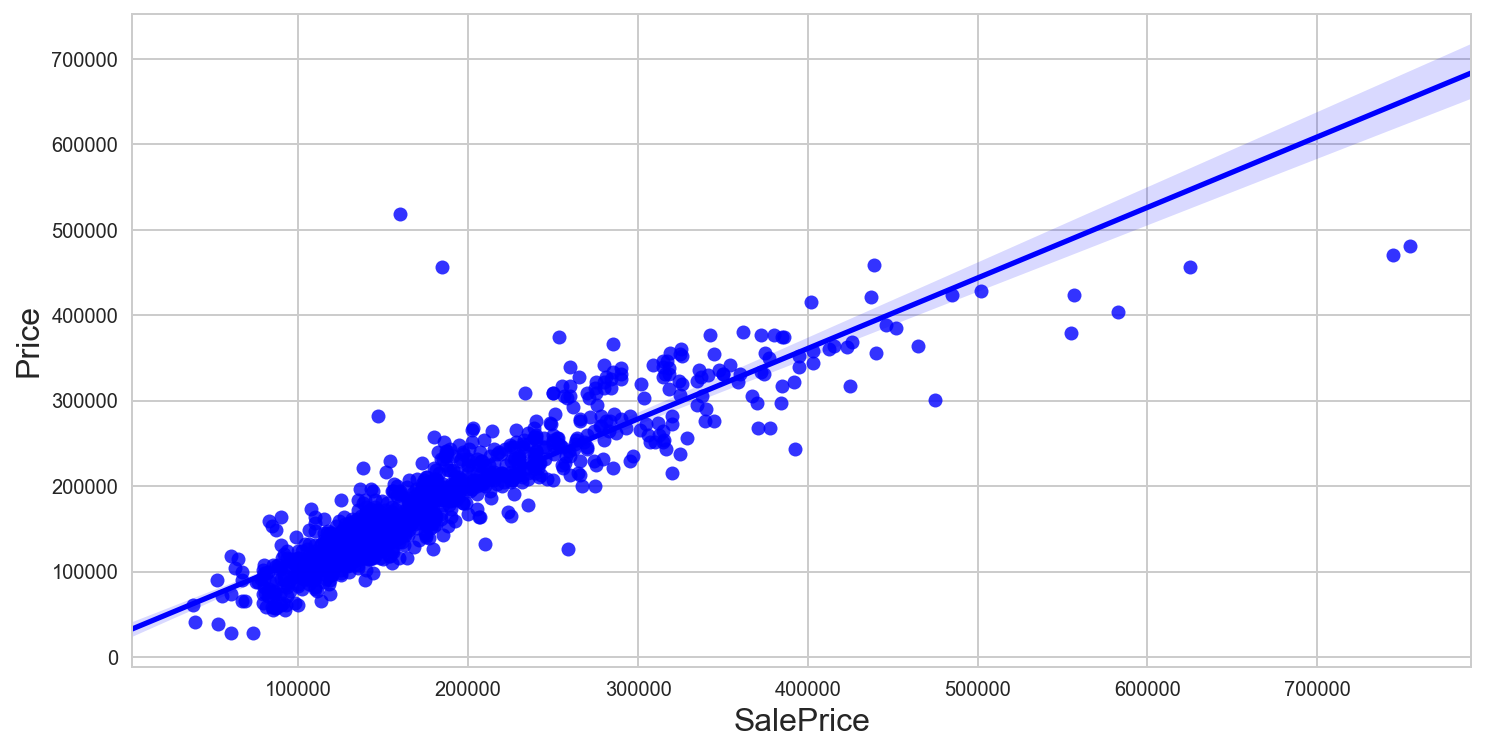

In [805]:
fig, ax_arr = plt.subplots(1,1, figsize=(12,6))

axis0 = sns.regplot(house_target_pre, pred_pre2010['Price'], color='blue', ax=ax_arr)

In [806]:
# Plotting a linear regression for the 2010 properties

X = house_2010
y = house_target

from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression(normalize=True)
lin_reg.fit(X, y)

pred_house_2010 = pd.DataFrame()
pred_house_2010['Price'] = lin_reg.predict(X)
lin_reg.score(X, y)

0.92177914694286289

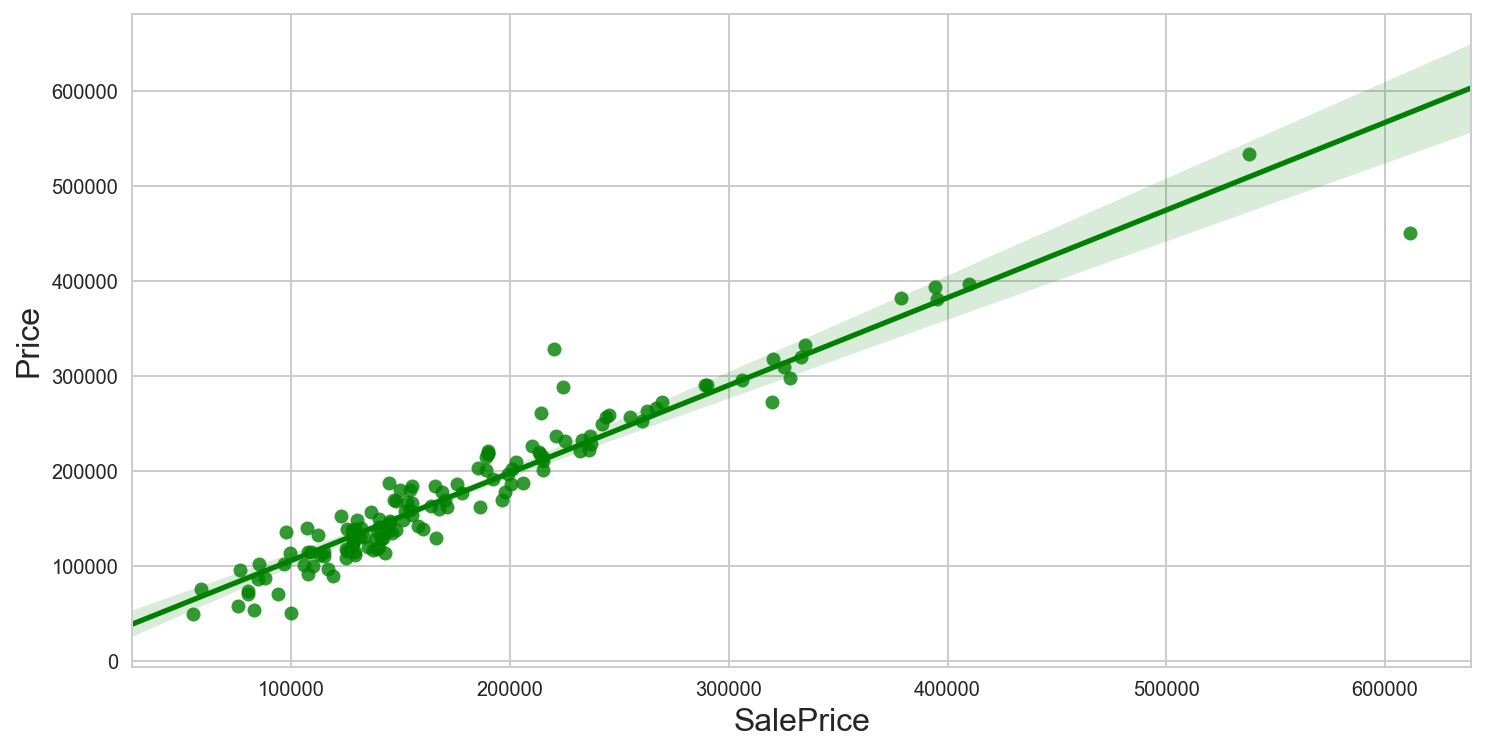

In [807]:
fig, ax_arr = plt.subplots(1,1, figsize=(12,6))

axis0 = sns.regplot(house_target, pred_house_2010['Price'], color='green', ax=ax_arr)

In [808]:
# Standizing
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaled_house_pre2010 = scaler.fit_transform(house_pre2010)
scaled_house_2010 = scaler.fit_transform(house_2010)

In [809]:
# Manually splitting the data between the pre/2010 datasets

X_train = scaled_house_pre2010
y_train = house_target_pre.astype(int).ravel()
X_test = scaled_house_2010
y_test = house_target.astype(int).ravel()

print 'X_train :', X_train.shape, '\n'
print 'y_train :', y_train.shape, '\n'
print 'X_test :', X_test.shape, '\n'
print 'y_test :', y_test.shape, '\n'

X_train : (1051, 79) 

y_train : (1051,) 

X_test : (140, 79) 

y_test : (140,) 



In [810]:
#Decision Tree

from sklearn.tree import DecisionTreeClassifier

clf_tree = DecisionTreeClassifier(max_depth=5)
clf_tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [811]:
clf_tree.fit_transform(X_test, y_test)
clf_tree.feature_importances_

/Users/noun/anaconda/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)


array([ 0.15053257,  0.09402861,  0.04614308,  0.        ,  0.1640482 ,
        0.23976263,  0.09241703,  0.05282184,  0.        ,  0.        ,
        0.05341534,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.03561023,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.03561023,
        0.        ,  0.        ,  0.        ,  0.03561023,  0.  

In [812]:
print 'Score:', clf_tree.score(X_test, y_test)

Score: 0.25


In [813]:
# Bagging and Classifying

clf_tree = DecisionTreeClassifier(max_depth = 5)
clf_tree.fit(X_train, y_train)
print 'Score:', clf_tree.score(X_test, y_test)

bagging = BaggingClassifier(base_estimator = clf_tree, max_samples=0.5, max_features=0.5)
bagging.fit(X_train, y_train)

print 'CLF Tree Score:\t', cross_val_score(clf_tree, X_train, y_train, cv=5, n_jobs=-1).mean()
print 'Bagging Score:\t', cross_val_score(bagging, X_train, y_train, cv=5, n_jobs=-1).mean()

Score: 0.00714285714286
CLF Tree Score:	0.0302181253262
Bagging Score:	0.0236699387519


In [814]:
# Using LassoCV to come up with best coefficients

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=5))
    return(rmse)

In [815]:
model_lasso = LassoCV(n_alphas=100, selection='random', max_iter=15000).fit(X_train, y_train)
res = rmse_cv(model_lasso)
print("Mean:",res.mean())
print("Min: ",res.min())

('Mean:', 39894.232972973172)
('Min: ', 29614.480295658486)


In [816]:
coef = pd.Series(model_lasso.coef_, index = house_2010.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")


Lasso picked 34 variables and eliminated the other 45 variables


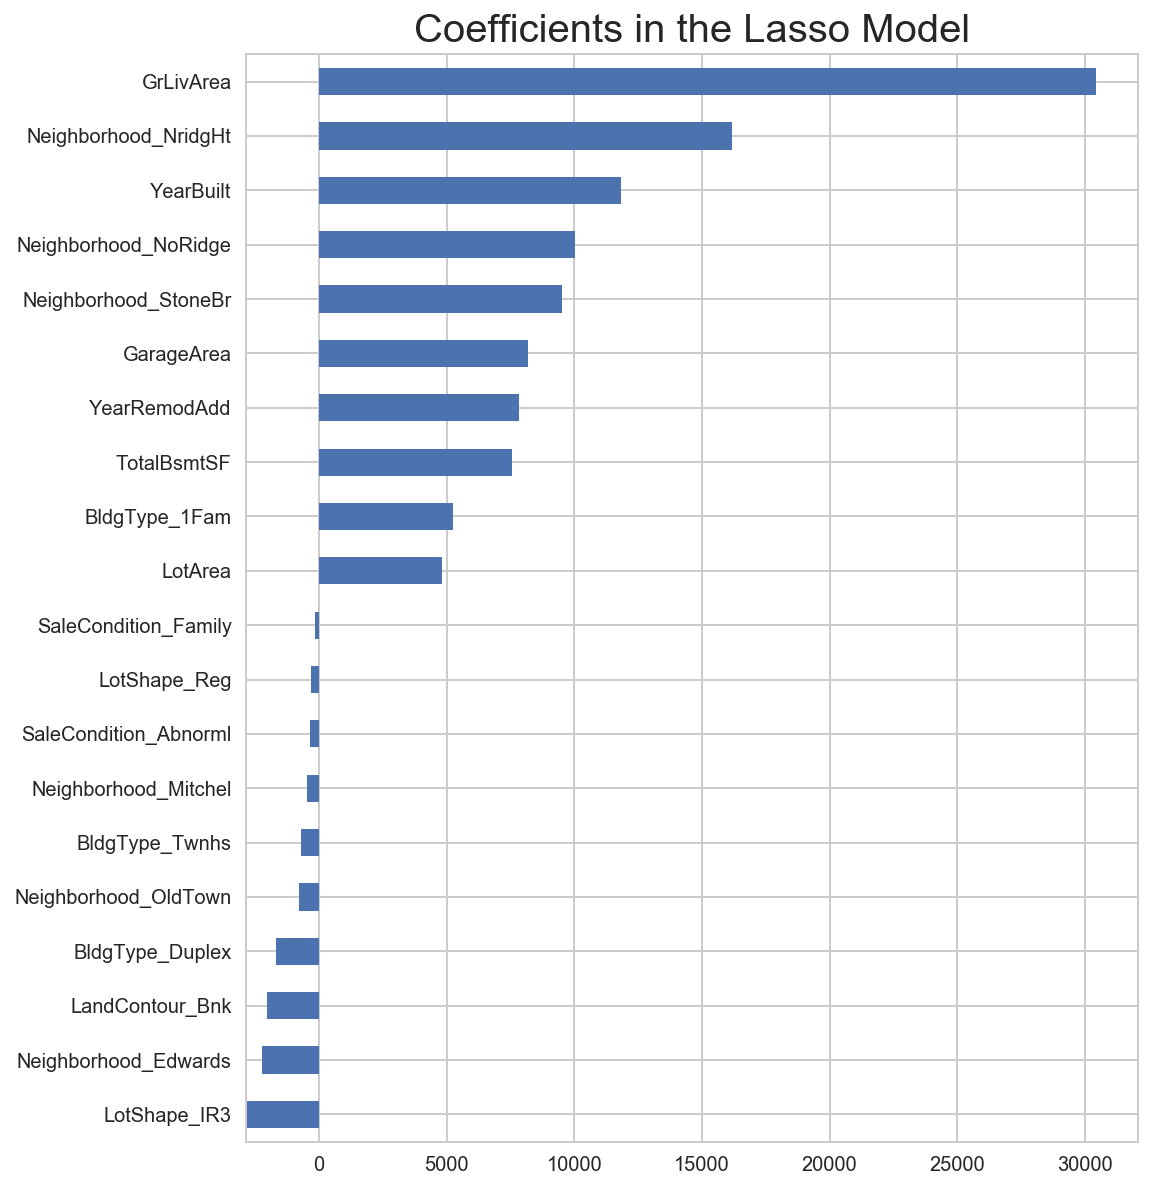

In [817]:
# Plotting the coefficients

imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

In [818]:
# Creating a DataFrame of the IDs and the predicted price

fixed_preds = model_lasso.predict(X_test)
pred = pd.DataFrame()
pred['predId'] = house_2010['Id']
pred["fixedPrediction"] = fixed_preds
pred['SalePrice'] = house_target
pred['Residual'] = np.round(pred['SalePrice'] - pred['fixedPrediction'], 2)

In [819]:
pred.head()

,predId,fixedPrediction,SalePrice,Residual
26,27,134471.220916,134800,328.78
27,28,312715.163281,306000,-6715.16
33,34,182193.508245,165500,-16693.51
38,39,136583.379012,109000,-27583.38
45,46,290086.471598,319900,29813.53


In [820]:
# Setting these aside for later

to_merge = pred[['predId', 'Residual']]

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?


- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

In [821]:
house.columns

Index([u'Id', u'MSSubClass', u'MSZoning', u'LotFrontage', u'LotArea',
       u'Street', u'Alley', u'LotShape', u'LandContour', u'Utilities',
       u'LotConfig', u'LandSlope', u'Neighborhood', u'Condition1',
       u'Condition2', u'BldgType', u'HouseStyle', u'OverallQual',
       u'OverallCond', u'YearBuilt', u'YearRemodAdd', u'RoofStyle',
       u'RoofMatl', u'Exterior1st', u'Exterior2nd', u'MasVnrType',
       u'MasVnrArea', u'ExterQual', u'ExterCond', u'Foundation', u'BsmtQual',
       u'BsmtCond', u'BsmtExposure', u'BsmtFinType1', u'BsmtFinSF1',
       u'BsmtFinType2', u'BsmtFinSF2', u'BsmtUnfSF', u'TotalBsmtSF',
       u'Heating', u'HeatingQC', u'CentralAir', u'Electrical', u'1stFlrSF',
       u'2ndFlrSF', u'LowQualFinSF', u'GrLivArea', u'BsmtFullBath',
       u'BsmtHalfBath', u'FullBath', u'HalfBath', u'BedroomAbvGr',
       u'KitchenAbvGr', u'KitchenQual', u'TotRmsAbvGrd', u'Functional',
       u'Fireplaces', u'FireplaceQu', u'GarageType', u'GarageYrBlt',
       u'GarageFinish',

In [822]:
# A: 

house_fixable_columns = ['Id', 'Utilities', 'Condition1', 'Condition2', 'OverallQual', \
                         'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', \
                         'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', \
                         'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', \
                         'BsmtFinSF2', 'BsmtUnfSF', 'Heating', 'HeatingQC', 'CentralAir', \
                         'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', \
                         'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', \
                         'PoolQC', 'Fence'
                        ]

house_fixable = house[house_fixable_columns]

In [823]:
house_fixable.dtypes

Id                int64
Utilities        object
Condition1       object
Condition2       object
OverallQual       int64
RoofStyle        object
RoofMatl         object
Exterior1st      object
Exterior2nd      object
MasVnrArea      float64
ExterQual        object
ExterCond        object
BsmtQual         object
BsmtCond         object
BsmtExposure     object
BsmtFinType1     object
BsmtFinSF1        int64
BsmtFinType2     object
BsmtFinSF2        int64
BsmtUnfSF         int64
Heating          object
HeatingQC        object
CentralAir       object
Electrical       object
KitchenQual      object
Functional       object
FireplaceQu      object
GarageFinish     object
GarageQual       object
GarageCond       object
PavedDrive       object
PoolQC           object
Fence            object
dtype: object

In [824]:
# Feature Engineering

dummy_columns = ['Utilities', 'Condition1', 'Condition2', 'RoofStyle', 'RoofMatl', \
                 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', \
                 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', \
                 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', \
                 'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', \
                 'PavedDrive', 'PoolQC', 'Fence'
                ]

house_dummies = pd.get_dummies(house[dummy_columns])

In [825]:
# Put it together

house_fixable = house_fixable.join(house_dummies)

In [826]:
# Drop these columns
droppers = ['Utilities', 'Condition1', 'Condition2', 'RoofStyle', 'RoofMatl', \
             'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', \
             'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', \
             'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', \
             'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', \
             'PavedDrive', 'PoolQC', 'Fence'
           ]

house_fixable = house_fixable.drop(droppers, axis=1)

In [827]:
# Put them together

house_fixable = house_fixable.merge(to_merge, left_on='Id', right_on=['predId'], how='outer')

In [828]:
# Get rid of the NaNs

house_fixable.dropna(inplace=True)

In [829]:
# And then check the correlations...

corr=house_fixable.corr()['Residual']
corr[np.argsort(corr, axis=0)[::-1]]

CentralAir_Y           0.009223
BsmtExposure_Gd        0.482561
Residual               1.000000
Exterior1st_ImStucc         NaN
Exterior2nd_MetalSd   -0.001651
Exterior2nd_AsbShng   -0.086476
Residual               1.000000
Residual               1.000000
Residual               1.000000
BsmtFinSF1             0.448722
MasVnrArea             0.304977
Condition2_Feedr       0.028265
BsmtFinType2_Rec      -0.043915
Residual               1.000000
Residual               1.000000
OverallQual            0.251053
Residual               1.000000
Exterior2nd_VinylSd   -0.023270
Residual               1.000000
Residual               1.000000
BsmtFinType1_Unf      -0.166870
Residual               1.000000
RoofStyle_Mansard     -0.053089
BsmtFinType2_BLQ      -0.037585
Condition2_RRNn             NaN
Exterior2nd_ImStucc   -0.016625
BsmtFinType1_Rec      -0.059551
Condition2_PosA             NaN
Exterior2nd_Stone           NaN
Exterior2nd_CmentBd    0.065453
                         ...   
BsmtCond

In [830]:
# Creating the target from the residual prices

fixable_target = house_fixable['Residual'].astype(int).ravel()

In [831]:
# Tests and targets

house_fixable = house_fixable.drop(['predId', 'Residual'], axis=1)
scaled_house_fixable = scaler.fit_transform(house_fixable)

In [832]:
X, y = scaled_house_fixable, fixable_target

In [833]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

print 'X_train :', X_train.shape, '\n'
print 'y_train :', y_train.shape, '\n'
print 'X_test :', X_test.shape, '\n'
print 'y_test :', y_test.shape, '\n'

X_train : (93, 160) 

y_train : (93,) 

X_test : (47, 160) 

y_test : (47,) 



In [834]:
# Using RidgeCV to come up with best coefficients

model_ridge = RidgeCV(alphas=(.001, .01, .1, 1, 10, 100)).fit(X_train, y_train)
res = rmse_cv(model_ridge)
print("Mean:",res.mean())
print("Min: ",res.min())

('Mean:', 28171.757219594077)
('Min: ', 19601.682139094162)


In [835]:
coef = pd.Series(model_ridge.coef_, index = house_fixable.columns)
print("Ridge picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")


Ridge picked 114 variables and eliminated the other 46 variables


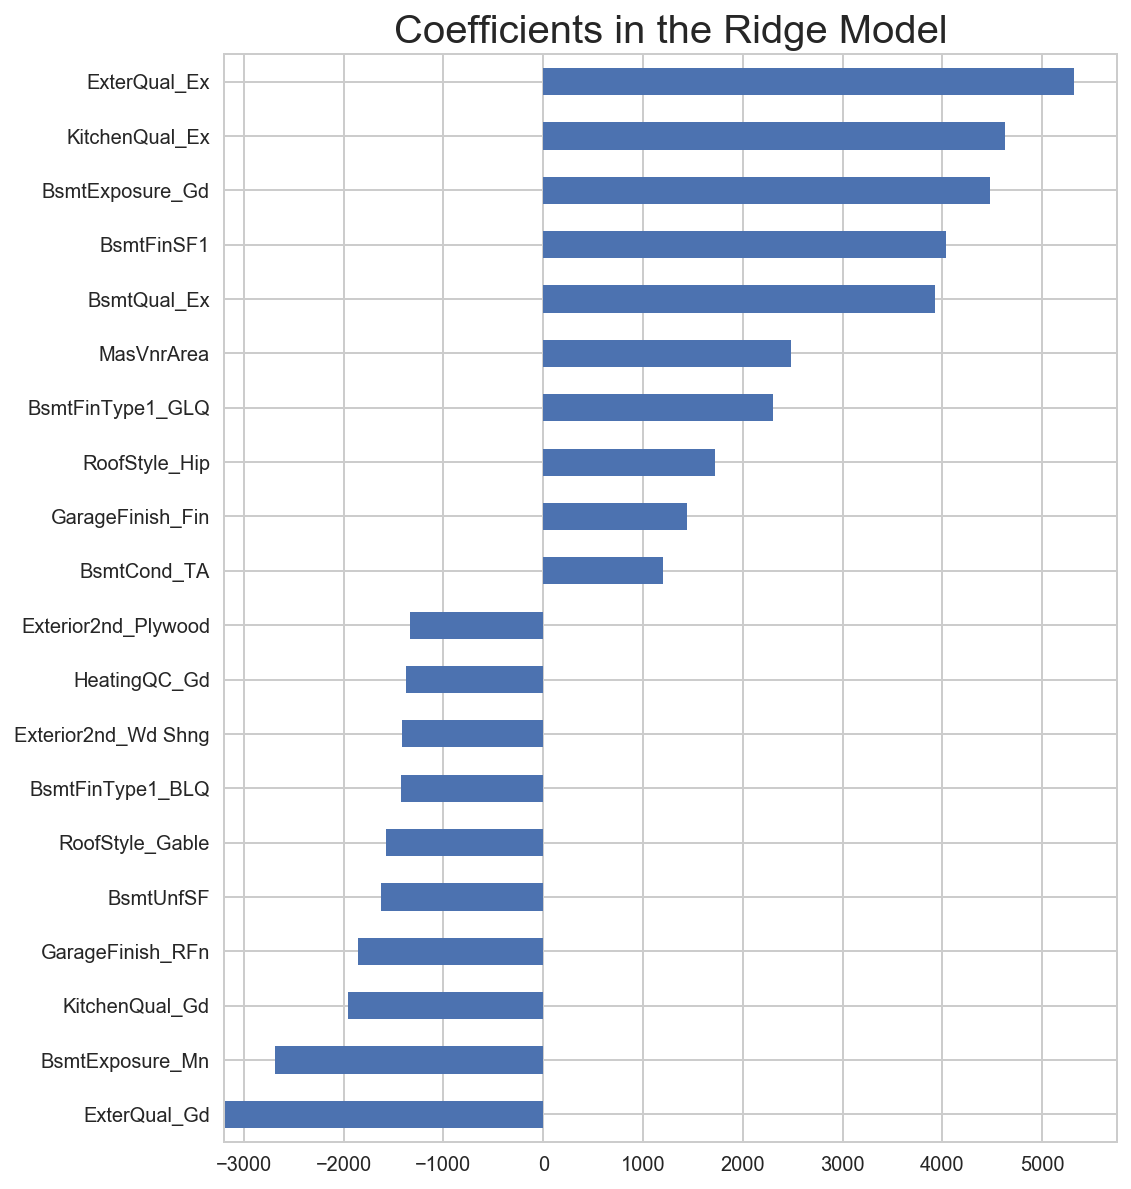

In [836]:
# Plotting the coefficients

imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")

In [837]:
# Creating a DataFrame of the ID and and renovate-able features sale prediction

reno_preds = model_ridge.predict(scaled_house_fixable)
reno = pd.DataFrame()
reno['renoId'] = house_fixable['Id']
reno['renoPrediction'] = reno_preds

In [838]:
# Putting all of the data together in one DataFrame

comparison = reno.merge(pred, left_on='renoId', right_on='predId', how='inner')
comparison = comparison.round({'renoPrediction': 2, 'fixedPrediction': 2, 'SalePrice': 2})

comparison.head()

,renoId,renoPrediction,predId,fixedPrediction,SalePrice,Residual
0,27,-20722.71,27,134471.22,134800,328.78
1,28,11050.98,28,312715.16,306000,-6715.16
2,34,-10523.56,34,182193.51,165500,-16693.51
3,39,5093.94,39,136583.38,109000,-27583.38
4,46,72246.73,46,290086.47,319900,29813.53


In [843]:
comparison['combinedPred'] = comparison['renoPrediction'] + comparison['fixedPrediction'] 
comparison['Residual'] = comparison['SalePrice'] - comparison['combinedPred']

In [844]:
np.round(comparison.Residual.mean(),decimals=2)

-543.85000000000002

In [845]:
comparison.head()

,renoId,renoPrediction,predId,fixedPrediction,SalePrice,Residual,combinedPred
0,27,-20722.71,27,134471.22,134800,21051.49,113748.51
1,28,11050.98,28,312715.16,306000,-17766.14,323766.14
2,34,-10523.56,34,182193.51,165500,-6169.95,171669.95
3,39,5093.94,39,136583.38,109000,-32677.32,141677.32
4,46,72246.73,46,290086.47,319900,-42433.20,362333.20


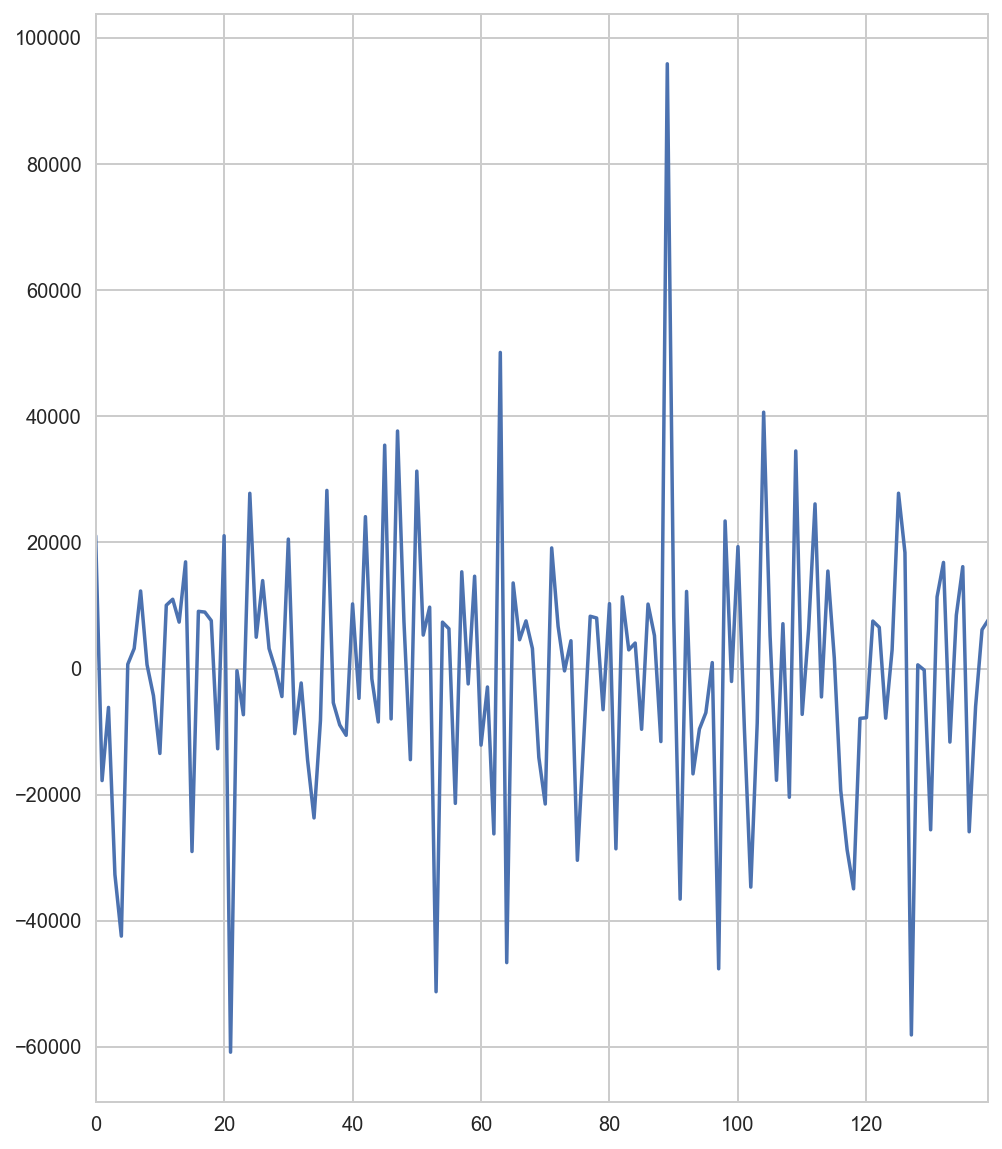

In [846]:
comparison.Residual.plot()

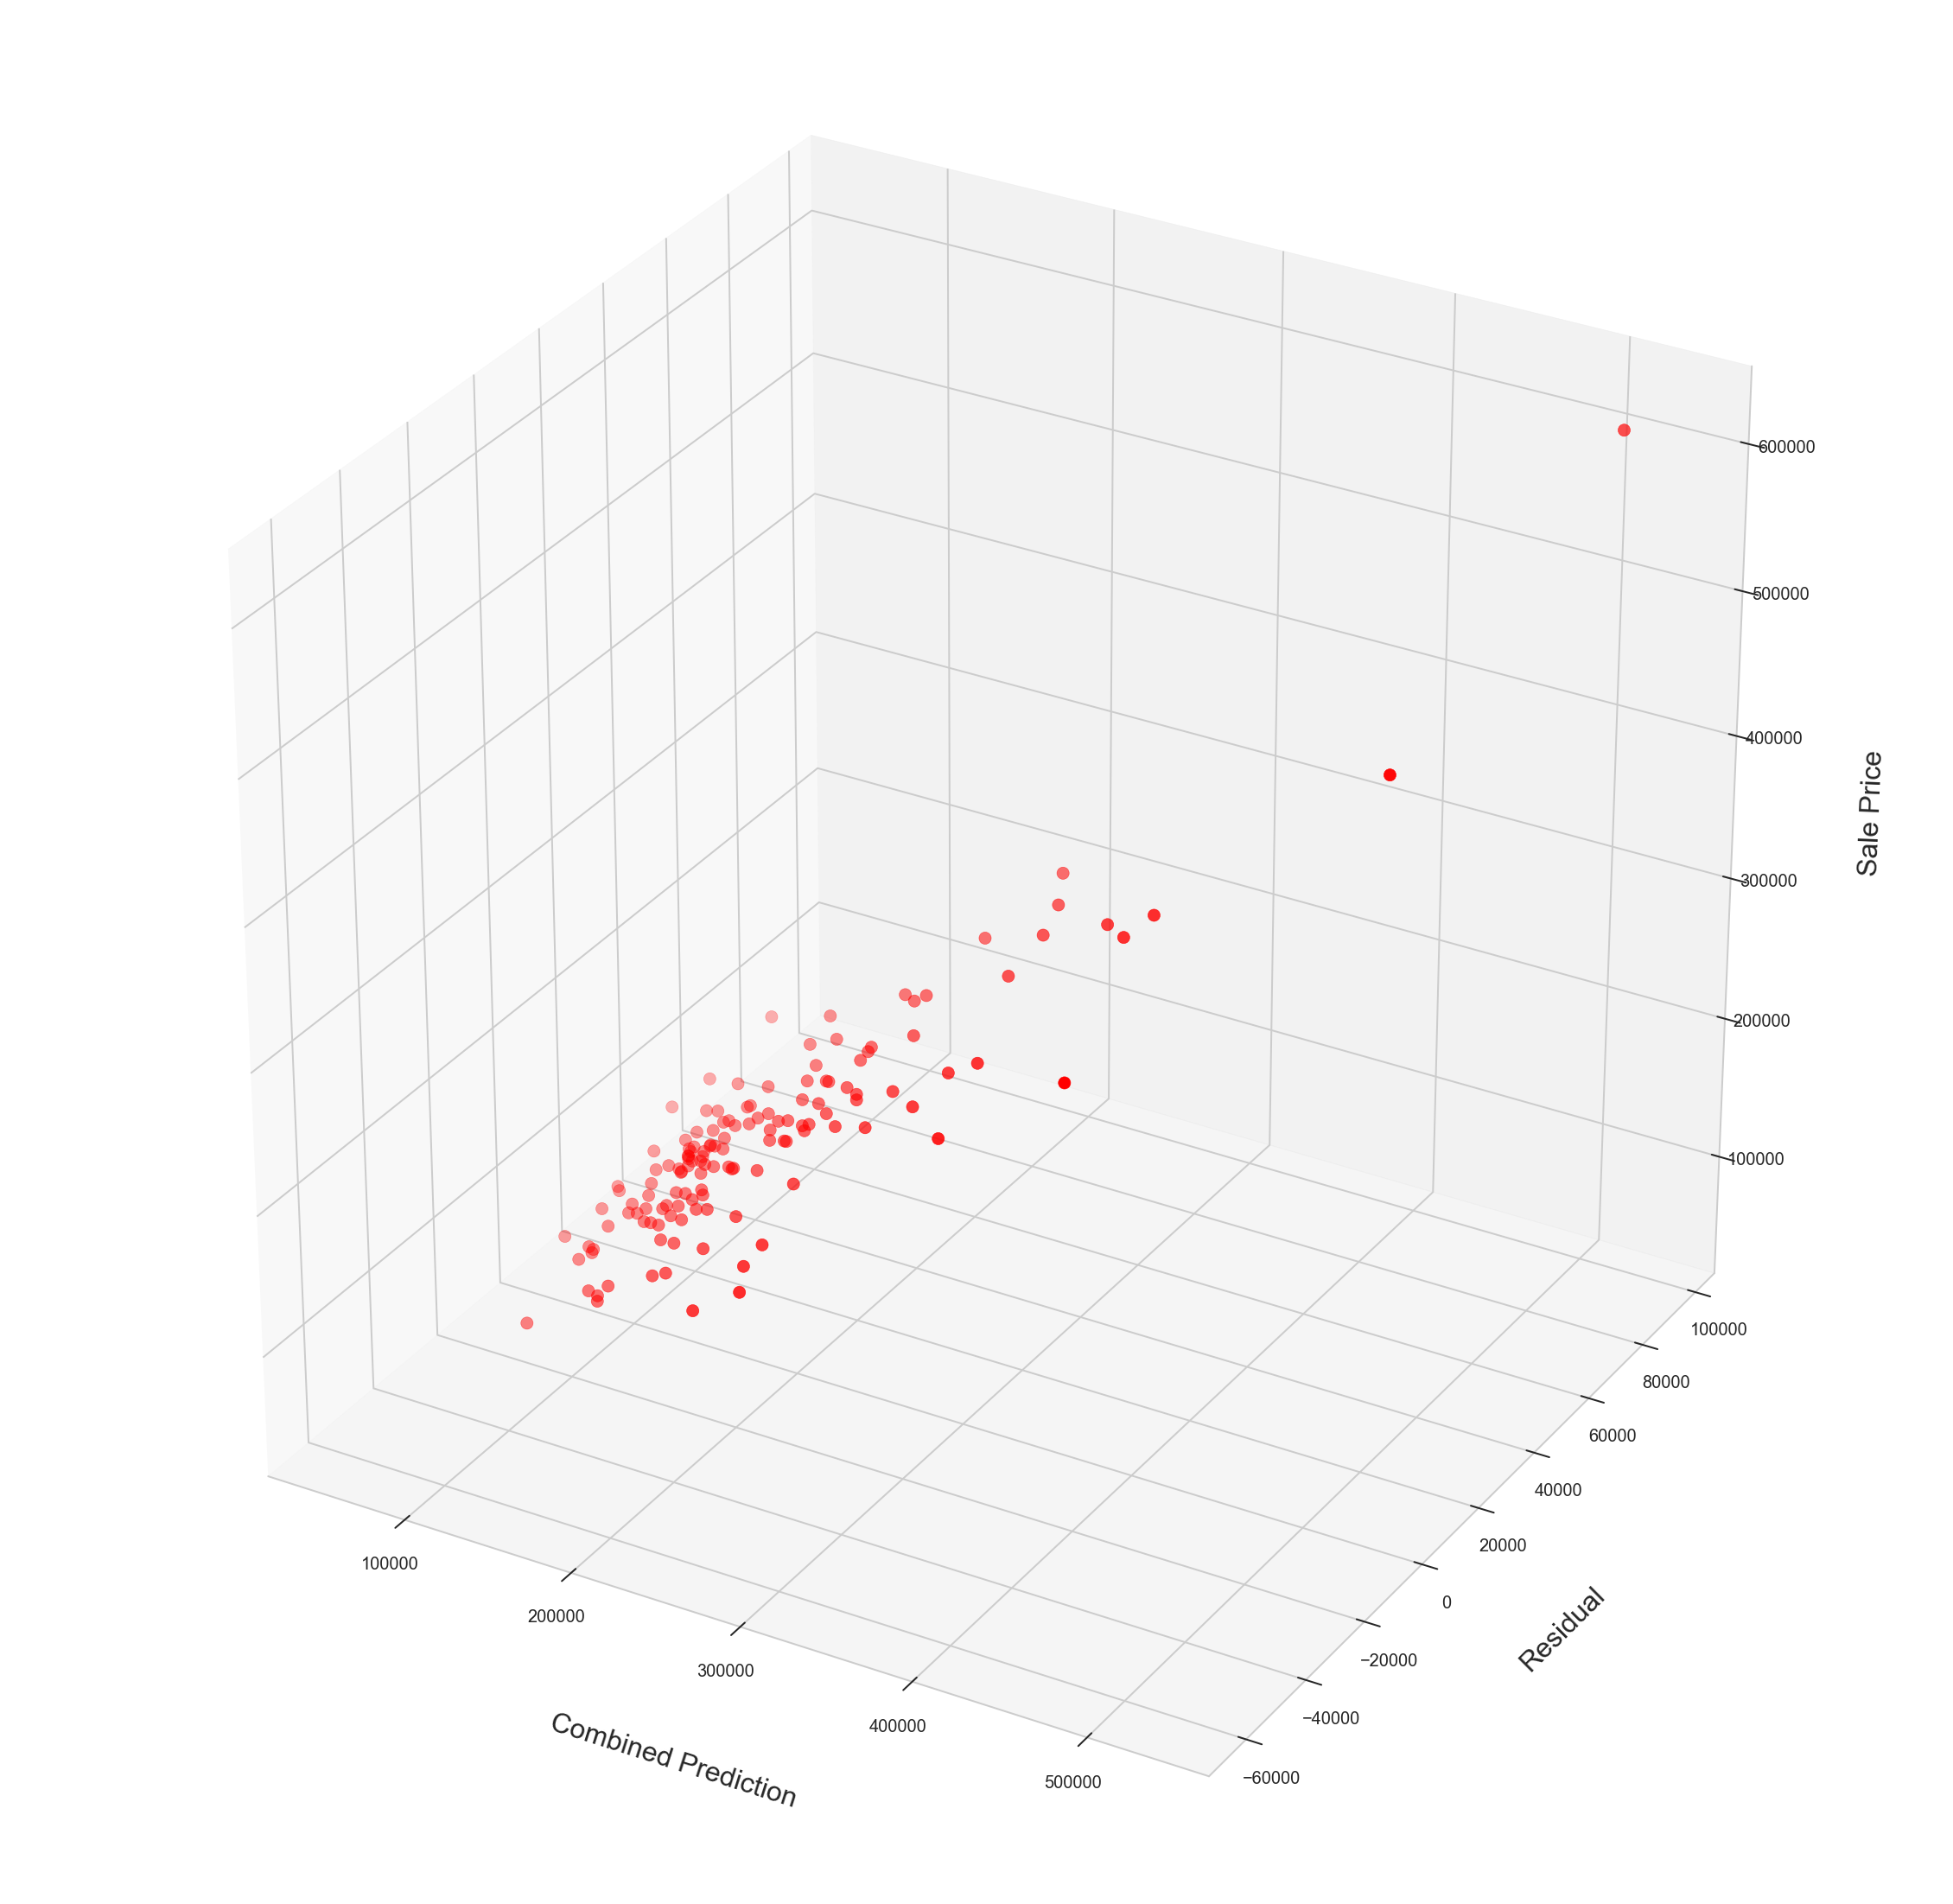

In [847]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')

x = comparison.combinedPred
y = comparison.Residual
z = comparison.SalePrice

ax.scatter(x, y, z, c='r', s=50, marker='o')

ax.set_xlabel('Combined Prediction')
ax.set_ylabel('Residual')
ax.set_zlabel('Sale Price')

ax.xaxis.labelpad=35
ax.yaxis.labelpad=35
ax.zaxis.labelpad=35


plt.show()

In [ ]:
# My model is only predicting OK.
# It tends to over-value properties.
# With more time, I would revisit the features to select more appropriate groupings.

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [ ]:
# A: